<a href="https://colab.research.google.com/github/BashayrA/Music-Genre-Classification/blob/main/FMA_genre_classification_models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Overview**
###🔺 **Supervised Task** (Labeled Classification)
#### **Goal:** Predict genres using labeled metadata and features.
#### Random Forest (Baseline).
CatBoost
#### XGBoost (High-performance).
###🔺 **Unsupervised Task** (Unlabeled Classification)
#### **Goal:** Group songs into clusters based on feature similarity.
#### HDBSCAN Clustering.
#### K-Means Clustering.
#### Multistage Clustering (HDBSCAN +K-MEAN)
###🔺 **Data Source**
#### FMA Dataset (Metadata and Audio Features).
###🔺**File to Use**
#### 📊 tracks.csv Main metadata
#### 🏷️ genres.csv Genre hierarchy used to extract target labels.
#### 🔢 features.csv Preprocessed audio features (statistical measurements like mean, max, etc.)

## ---------------------------------------------------------
## 📊 **EDA Step: Understanding the Data**
## ---------------------------------------------------------


In [ ]:
!wget -q --show-progress https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!unzip -qo fma_metadata.zip -d fma_metadata
!ls -lah fma_metadata | sed -n '1,120p'

fma_metadata.zip    100%[===================>] 341.81M  23.3MB/s    in 16s     
total 12K
drwxr-xr-x 3 root root 4.0K Dec 12 23:01 .
drwxr-xr-x 1 root root 4.0K Dec 12 23:01 ..
drwxr-xr-x 2 root root 4.0K Dec 12 23:02 fma_metadata


In [ ]:
# imports
from pathlib import Path
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import umap
import hdbscan

ModuleNotFoundError: No module named 'catboost'

In [ ]:
# Load The Dataset
tracks = pd.read_csv("/content/fma_metadata/fma_metadata/tracks.csv", header=[0,1])
features = pd.read_csv("/content/fma_metadata/fma_metadata/features.csv", header=[0,1,2])
genres = pd.read_csv("/content/fma_metadata/fma_metadata/genres.csv")

/tmp/ipython-input-1186503760.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks = pd.read_csv("/content/fma_metadata/fma_metadata/tracks.csv", header=[0,1])
/tmp/ipython-input-1186503760.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  features = pd.read_csv("/content/fma_metadata/fma_metadata/features.csv", header=[0,1,2])


In [ ]:
# Drive setup (for saving progress only)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/Our_Project"

In [ ]:
os.makedirs(PROJECT_DIR, exist_ok=True)

### Tracks - EDA

In [ ]:
print("Tracks Shape:")
tracks.shape

Tracks Shape:


(106575, 53)

In [ ]:
print("Tracks Head:")
tracks.head()

Tracks Head:


Unnamed: 0_level_0    album                                            \
  Unnamed: 0_level_1 comments         date_created        date_released   
0           track_id      NaN                  NaN                  NaN   
1                  2      0.0  2008-11-26 01:44:45  2009-01-05 00:00:00   
2                  3      0.0  2008-11-26 01:44:45  2009-01-05 00:00:00   
3                  5      0.0  2008-11-26 01:44:45  2009-01-05 00:00:00   
4                 10      0.0  2008-11-26 01:45:08  2008-02-06 00:00:00   

                                                         ...       track  \
  engineer favorites   id information  listens producer  ... information   
0      NaN       NaN  NaN         NaN      NaN      NaN  ...         NaN   
1      NaN       4.0  1.0     <p></p>   6073.0      NaN  ...         NaN   
2      NaN       4.0  1.0     <p></p>   6073.0      NaN  ...         NaN   
3      NaN       4.0  1.0     <p></p>   6073.0      NaN  ...         NaN   
4      NaN       4.0  6.0         NaN  47632.0      NaN  ...         NaN   

                                                                             \
  interest language_code                                            license   
0      NaN           NaN                                                NaN   
1   4656.0            en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
2   1470.0            en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
3   1933.0            en  Attribution-NonCommercial-ShareAlike 3.0 Inter...   
4  54881.0            en  Attribution-NonCommercial-NoDerivatives (aka M...   

                                                         
   listens lyricist number publisher tags         title  
0      NaN      NaN    NaN       NaN  NaN           NaN  
1   1293.0      NaN    3.0       NaN   []          Food  
2    514.0      NaN    4.0       NaN   []  Electric Ave  
3   1151.0      NaN    6.0       NaN   []    This World  
4  50135.0      NaN    1.0       NaN   []       Freeway  

[5 rows x 53 columns]

In [ ]:
print("Tracks Info:")
tracks.info()

Tracks Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106575 entries, 0 to 106574
Data columns (total 53 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   (Unnamed: 0_level_0, Unnamed: 0_level_1)  106575 non-null  object 
 1   (album, comments)                         106574 non-null  float64
 2   (album, date_created)                     103045 non-null  object 
 3   (album, date_released)                    70294 non-null   object 
 4   (album, engineer)                         15295 non-null   object 
 5   (album, favorites)                        106574 non-null  float64
 6   (album, id)                               106574 non-null  float64
 7   (album, information)                      83149 non-null   object 
 8   (album, listens)                          106574 non-null  float64
 9   (album, producer)                         18060 non-null   object 
 10  (album,

In [ ]:
print("Tracks Describe:")
tracks.describe()

Tracks Describe:


album                                              \
            comments      favorites             id       listens   
count  106574.000000  106574.000000  106574.000000  1.065740e+05   
mean        0.394946       1.286927   12826.933914  3.212031e+04   
std         2.268915       3.133035    6290.261805  1.478532e+05   
min        -1.000000      -1.000000      -1.000000 -1.000000e+00   
25%         0.000000       0.000000    7793.000000  3.361000e+03   
50%         0.000000       0.000000   13374.000000  8.982000e+03   
75%         0.000000       1.000000   18203.000000  2.363500e+04   
max        53.000000      61.000000   22940.000000  3.564243e+06   

                             artist                                \
              tracks       comments      favorites             id   
count  106574.000000  106574.000000  106574.000000  106574.000000   
mean       19.721452       1.894702      30.041915   12036.770404   
std        39.943673       6.297679     100.511408    6881.420867   
min        -1.000000      -1.000000      -1.000000       1.000000   
25%         7.000000       0.000000       1.000000    6443.000000   
50%        11.000000       0.000000       5.000000   12029.500000   
75%        17.000000       1.000000      16.000000   18011.000000   
max       652.000000      79.000000     963.000000   24357.000000   

                                           track                 \
           latitude     longitude       bit_rate       comments   
count  44544.000000  44544.000000  106574.000000  106574.000000   
mean      39.901626    -38.668642  263274.695048       0.031621   
std       18.240860     65.237220   67623.443584       0.321993   
min      -45.878760   -157.526855      -1.000000       0.000000   
25%       39.271398    -79.997459  192000.000000       0.000000   
50%       41.387917    -73.554431  299914.000000       0.000000   
75%       48.856930      4.351710  320000.000000       0.000000   
max       67.286005    175.277000  448000.000000      37.000000   

                                                                  \
            duration      favorites      interest        listens   
count  106574.000000  106574.000000  1.065740e+05  106574.000000   
mean      277.849100       3.182521  3.541310e+03    2329.353548   
std       305.518553      13.513820  1.901743e+04    8028.070647   
min         0.000000       0.000000  2.000000e+00       0.000000   
25%       149.000000       0.000000  5.990000e+02     292.000000   
50%       216.000000       1.000000  1.314000e+03     764.000000   
75%       305.000000       3.000000  3.059000e+03    2018.000000   
max     18350.000000    1482.000000  3.293557e+06  543252.000000   

                      
              number  
count  106574.000000  
mean        8.260945  
std        15.243271  
min         0.000000  
25%         2.000000  
50%         5.000000  
75%         9.000000  
max       255.000000

In [ ]:
# Check Missing Values
tracks.isnull().sum()

Unnamed: 0_level_0  Unnamed: 0_level_1         0
album               comments                   1
                    date_created            3530
                    date_released          36281
                    engineer               91280
                    favorites                  1
                    id                         1
                    information            23426
                    listens                    1
                    producer               88515
                    tags                       1
                    title                   1026
                    tracks                     1
                    type                    6509
artist              active_year_begin      83864
                    active_year_end       101200
                    associated_labels      92304
                    bio                    35419
                    comments                   1
                    date_created             857
                    favorites                  1
                    id                         1
                    latitude               62031
                    location               36365
                    longitude              62031
                    members                59726
                    name                       1
                    related_projects       93423
                    tags                       1
                    website                27319
                    wikipedia_page        100994
set                 split                      1
                    subset                     1
track               bit_rate                   1
                    comments                   1
                    composer              102905
                    date_created               1
                    date_recorded         100416
                    duration                   1
                    favorites                  1
                    genre_top              56977
                    genres                     1
                    genres_all                 1
                    information           104226
                    interest                   1
                    language_code          91551
                    license                   88
                    listens                    1
                    lyricist              106264
                    number                     1
                    publisher             105312
                    tags                       1
                    title                      2
dtype: int64

In [ ]:
tracks['track']['genre_top']

0             NaN
1         Hip-Hop
2         Hip-Hop
3         Hip-Hop
4             Pop
           ...   
106570       Rock
106571       Rock
106572       Rock
106573       Rock
106574        NaN
Name: genre_top, Length: 106575, dtype: object

In [ ]:
tracks['track']['genres_all']

0                      NaN
1                     [21]
2                     [21]
3                     [21]
4                     [10]
                ...       
106570            [25, 12]
106571            [25, 12]
106572            [25, 12]
106573            [25, 12]
106574    [169, 10, 12, 9]
Name: genres_all, Length: 106575, dtype: object

In [ ]:
tracks['track']['genres']

0                   NaN
1                  [21]
2                  [21]
3                  [21]
4                  [10]
              ...      
106570             [25]
106571             [25]
106572             [25]
106573             [25]
106574    [10, 12, 169]
Name: genres, Length: 106575, dtype: object

In [ ]:
# Check Unique Counts
print(f"Total Unique Artists: {tracks['artist']['name'].nunique()}")
print(f"Total Unique Albums: {tracks['album']['title'].nunique()}")
tracks['track']['language_code'].value_counts()

Total Unique Artists: 16294
Total Unique Albums: 14298


language_code
en    14255
es      204
fr      191
pt       81
de       68
ru       30
it       28
tr       25
sr       23
pl       12
he       12
ar       12
bg        7
el        7
ee        7
ja        6
fi        6
sw        6
cs        5
nl        5
zh        3
hi        3
id        3
hy        2
az        2
ms        2
vi        2
tw        1
eu        1
uk        1
lt        1
gu        1
ty        1
tl        1
my        1
th        1
ha        1
ka        1
uz        1
ko        1
no        1
sk        1
bm        1
la        1
Name: count, dtype: int64

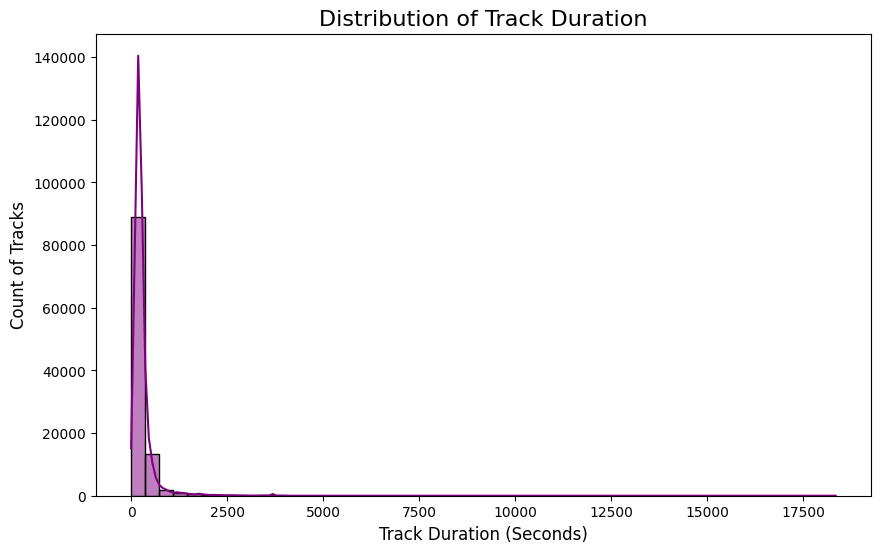

In [ ]:
# Track Duration Distribution
plt.figure(figsize=(10, 6))
sns.histplot(tracks['track']['duration'],bins=50,kde=True,color='purple')
plt.title('Distribution of Track Duration', fontsize=16)
plt.xlabel('Track Duration (Seconds)', fontsize=12)
plt.ylabel('Count of Tracks', fontsize=12)
plt.show()

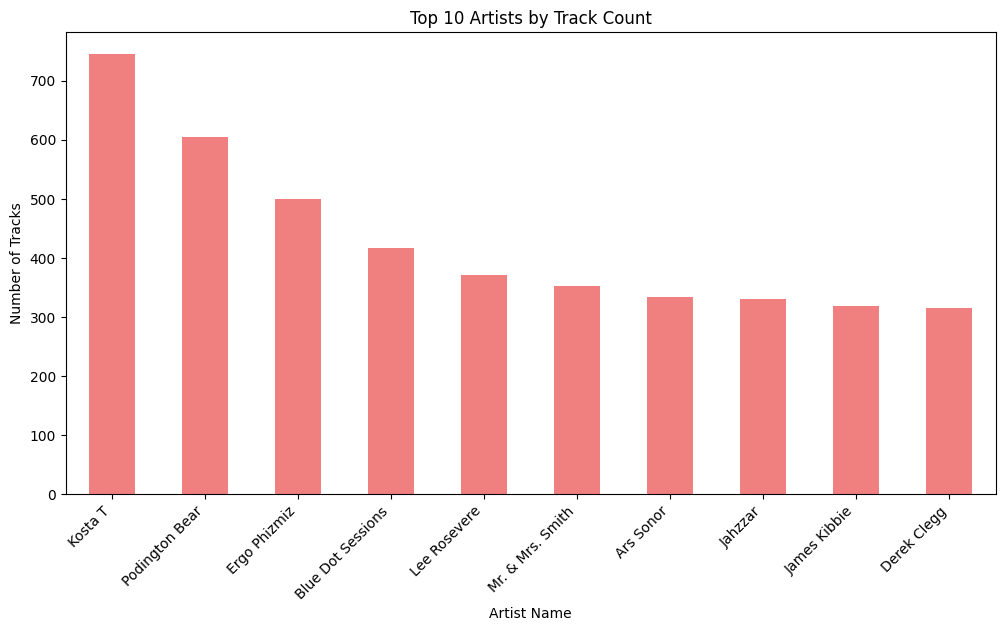

In [ ]:
# Plotting the top 10 artists by number of tracks
top_artists = tracks['artist']['name'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_artists.plot(kind='bar', color='lightcoral')
plt.title('Top 10 Artists by Track Count')
plt.xlabel('Artist Name')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Check for missing values in the target column
missing_genres = tracks['track']['genre_top'].isnull().sum()
print(f"Tracks without Genre Label: {missing_genres}")

Tracks without Genre Label: 56977


In [ ]:
# Check for Duplicates
print("Tracks Duplicates:", tracks.duplicated().sum())

Tracks Duplicates: 0


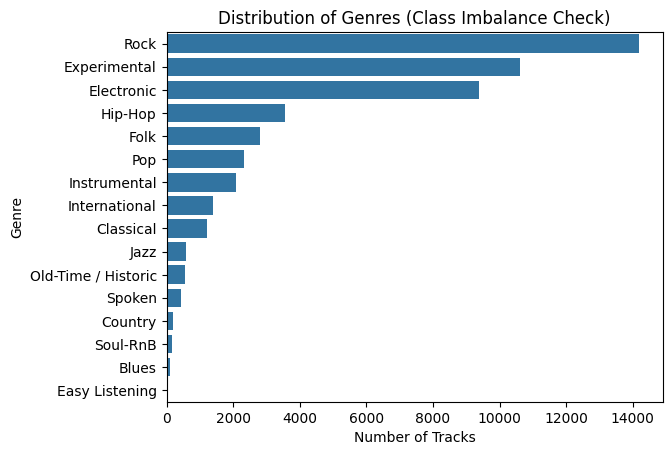

In [ ]:
subset_with_genres = tracks[tracks['track']['genre_top'].notnull()]
sns.countplot(y=subset_with_genres['track']['genre_top'], order=subset_with_genres['track']['genre_top'].value_counts().index)
plt.title('Distribution of Genres (Class Imbalance Check)')
plt.xlabel('Number of Tracks')
plt.ylabel('Genre')
plt.show()

#### **Alert !!!**



A clear **class imbalance** issue has been detected in the dataset where a few genres dominate the distribution while others have very limited samples which may negatively impact model performance

### Features - EDA

In [ ]:
print("Features Shape:")
features.shape

Features Shape:


(106575, 519)

In [ ]:
print("Features Head:")
features.iloc[:, :10].head()

Features Head:


feature chroma_cens                                                    \
  statistics    kurtosis                                                     
      number          01        02        03        04        05        06   
0   track_id         NaN       NaN       NaN       NaN       NaN       NaN   
1          2    7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
2          3    1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
3          5    0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
4         10    3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   

                                 
                                 
         07        08        09  
0       NaN       NaN       NaN  
1  1.481593  2.691455  0.866868  
2  1.366848  1.054094  0.108103  
3 -0.923192 -0.927232  0.666617  
4  1.770694  1.604566  0.521217

In [ ]:
print("Features Info:")
features.info()

Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106575 entries, 0 to 106574
Columns: 519 entries, ('feature', 'statistics', 'number') to ('zcr', 'std', '01')
dtypes: float64(518), object(1)
memory usage: 422.0+ MB


In [ ]:
features.iloc[:, :10].describe()

chroma_cens                                               \
            kurtosis                                                
                  01             02             03             04   
count  106574.000000  106574.000000  106574.000000  106574.000000   
mean        0.439999       0.199756       0.334683       0.270263   
std        32.285524      11.120903       9.980692      19.074557   
min        -1.955806      -1.936607      -1.967450      -3.000000   
25%        -0.636597      -0.665684      -0.629114      -0.644747   
50%        -0.176557      -0.221131      -0.152708      -0.191032   
75%         0.485000       0.410097       0.529836       0.446800   
max      8843.367188    2864.075195    1777.615967    4257.045898   

                                                                   \
                                                                    
                  05             06             07             08   
count  106574.000000  106574.000000  106574.000000  106574.000000   
mean        0.294806       0.315635       0.273511       0.334927   
std        15.025603      12.176182      16.975991      15.486402   
min        -1.921206      -1.923740      -1.935382      -3.000000   
25%        -0.656779      -0.622579      -0.646798      -0.635741   
50%        -0.198025      -0.152089      -0.187959      -0.161478   
75%         0.452680       0.513112       0.472161       0.525814   
max      3188.034424    2809.779297    4281.090820    3869.482178   

                      
                      
                  09  
count  106574.000000  
mean        0.201939  
std         7.364308  
min        -3.000000  
25%        -0.667799  
50%        -0.214547  
75%         0.432480  
max      1217.209473

In [ ]:
# Check Missing Values
tracks.isnull().sum()

Unnamed: 0_level_0  Unnamed: 0_level_1         0
album               comments                   1
                    date_created            3530
                    date_released          36281
                    engineer               91280
                    favorites                  1
                    id                         1
                    information            23426
                    listens                    1
                    producer               88515
                    tags                       1
                    title                   1026
                    tracks                     1
                    type                    6509
artist              active_year_begin      83864
                    active_year_end       101200
                    associated_labels      92304
                    bio                    35419
                    comments                   1
                    date_created             857
                    favorites                  1
                    id                         1
                    latitude               62031
                    location               36365
                    longitude              62031
                    members                59726
                    name                       1
                    related_projects       93423
                    tags                       1
                    website                27319
                    wikipedia_page        100994
set                 split                      1
                    subset                     1
track               bit_rate                   1
                    comments                   1
                    composer              102905
                    date_created               1
                    date_recorded         100416
                    duration                   1
                    favorites                  1
                    genre_top              56977
                    genres                     1
                    genres_all                 1
                    information           104226
                    interest                   1
                    language_code          91551
                    license                   88
                    listens                    1
                    lyricist              106264
                    number                     1
                    publisher             105312
                    tags                       1
                    title                      2
dtype: int64

In [ ]:
# Check for Duplicates
print("Features Duplicates:", features.duplicated().sum())

Features Duplicates: 0


In [ ]:
features.columns

MultiIndex([(    'feature', 'statistics', 'number'),
            ('chroma_cens',   'kurtosis',     '01'),
            ('chroma_cens',   'kurtosis',     '02'),
            ('chroma_cens',   'kurtosis',     '03'),
            ('chroma_cens',   'kurtosis',     '04'),
            ('chroma_cens',   'kurtosis',     '05'),
            ('chroma_cens',   'kurtosis',     '06'),
            ('chroma_cens',   'kurtosis',     '07'),
            ('chroma_cens',   'kurtosis',     '08'),
            ('chroma_cens',   'kurtosis',     '09'),
            ...
            (    'tonnetz',        'std',     '04'),
            (    'tonnetz',        'std',     '05'),
            (    'tonnetz',        'std',     '06'),
            (        'zcr',   'kurtosis',     '01'),
            (        'zcr',        'max',     '01'),
            (        'zcr',       'mean',     '01'),
            (        'zcr',     'median',     '01'),
            (        'zcr',        'min',     '01'),
            (        'zcr',   

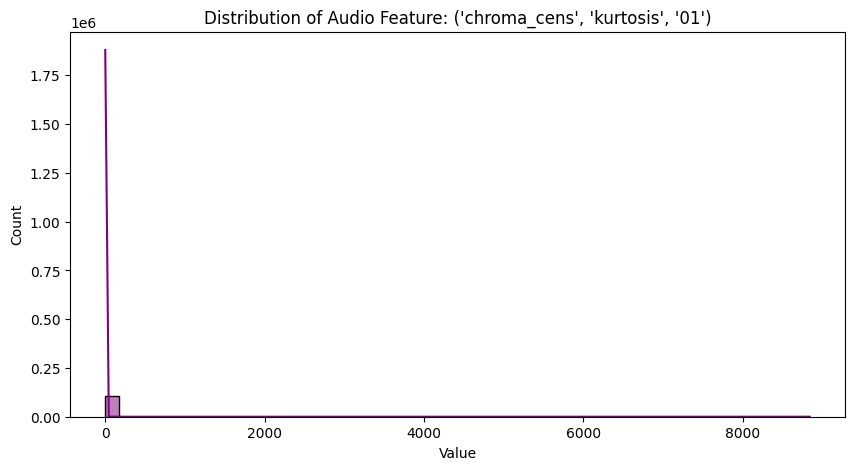

In [ ]:
sample_feature = ('chroma_cens', 'kurtosis', '01')
plt.figure(figsize=(10, 5))
sns.histplot(features[sample_feature], kde=True, bins=50, color='purple')
plt.title(f'Distribution of Audio Feature: {sample_feature}')
plt.xlabel('Value')
plt.show()

#### **Alert!!!**
the feature chroma_cens_kurtosis_01 shows an extremely skewed distribution with strong outliers where most values are concentrated near zero while a few very large values stretch the scale

this may require normalization or outlier handling before modeling

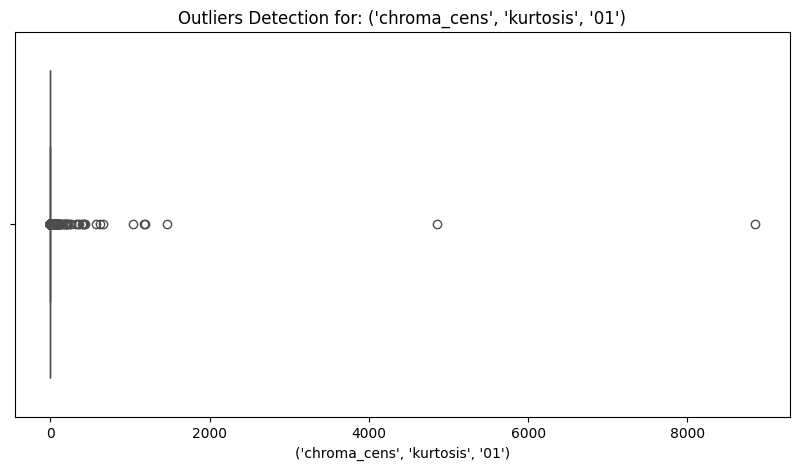

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=features[sample_feature], color='orange')
plt.title(f'Outliers Detection for: {sample_feature}')
plt.show()

#### **Alert!!!**
the feature chroma_cens_kurtosis_01 contains extreme outliers far from the main range, which may negatively affect model performance

### Genres - EDA

In [ ]:
print("Genres Shape:")
genres.shape

Genres Shape:


(163, 5)

In [ ]:
print("Genres Head:")
genres.head(10)

Genres Head:


genre_id  #tracks  parent                title  top_level
0         1     8693      38          Avant-Garde         38
1         2     5271       0        International          2
2         3     1752       0                Blues          3
3         4     4126       0                 Jazz          4
4         5     4106       0            Classical          5
5         6      914      38              Novelty         38
6         7      217      20               Comedy         20
7         8      868       0  Old-Time / Historic          8
8         9     1987       0              Country          9
9        10    13845       0                  Pop         10

In [ ]:
print("Genres Info:")
genres.info()

Genres Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   genre_id   163 non-null    int64 
 1   #tracks    163 non-null    int64 
 2   parent     163 non-null    int64 
 3   title      163 non-null    object
 4   top_level  163 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 6.5+ KB


In [ ]:
print("Genres Describe:")
genres.describe()

Genres Describe:


genre_id       #tracks       parent    top_level
count   163.000000    163.000000   163.000000   163.000000
mean    254.116564   2142.085890    60.447853    51.374233
std     265.048642   5199.542574   185.396011   211.470836
min       1.000000      0.000000     0.000000     2.000000
25%      60.500000    125.000000     5.000000     5.000000
50%     172.000000    563.000000    15.000000    12.000000
75%     400.500000   1846.500000    38.000000    20.000000
max    1235.000000  38154.000000  1235.000000  1235.000000

In [ ]:
#Check Missing Values
genres.isnull().sum()

genre_id     0
#tracks      0
parent       0
title        0
top_level    0
dtype: int64

In [ ]:
# Checks for Duplicates
print("Genres Duplicates:", genres.duplicated().sum())

Genres Duplicates: 0


Total Root Genres: 16
Total Sub-Genres: 147


/tmp/ipython-input-4096610552.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=most_branched.values, y=most_branched_names, palette='viridis')


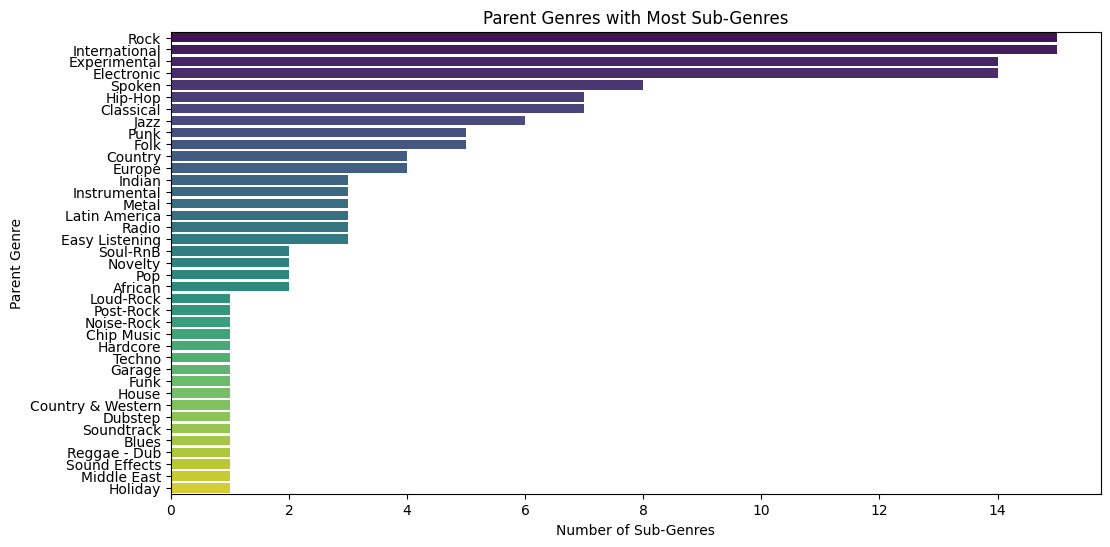

In [ ]:
roots = genres[genres['parent'] == 0]
sub_genres = genres[genres['parent'] != 0]
print(f"Total Root Genres: {len(roots)}")
print(f"Total Sub-Genres: {len(sub_genres)}")
most_branched = sub_genres['parent'].value_counts()
id_to_title = genres.set_index('genre_id')['title']
most_branched_names = id_to_title.reindex(most_branched.index)
plt.figure(figsize=(12, 6))
sns.barplot(x=most_branched.values, y=most_branched_names, palette='viridis')
plt.title('Parent Genres with Most Sub-Genres')
plt.xlabel('Number of Sub-Genres')
plt.ylabel('Parent Genre')
plt.show()

## ---------------------------------------------------------
## 🛠️ **Preprocessing Step: Prepare data for modeling**
## ---------------------------------------------------------

Flat the columns of features and tracks

In [ ]:
# We noticed the data had a MultiIndex, so we flattened it to make columns easier to handle and analyze
tracks.columns = ['_'.join(col).strip() for col in tracks.columns.values]
tracks.head()

Unnamed: 0_level_0_Unnamed: 0_level_1  album_comments   album_date_created  \
0                              track_id             NaN                  NaN   
1                                     2             0.0  2008-11-26 01:44:45   
2                                     3             0.0  2008-11-26 01:44:45   
3                                     5             0.0  2008-11-26 01:44:45   
4                                    10             0.0  2008-11-26 01:45:08   

   album_date_released album_engineer  album_favorites  album_id  \
0                  NaN            NaN              NaN       NaN   
1  2009-01-05 00:00:00            NaN              4.0       1.0   
2  2009-01-05 00:00:00            NaN              4.0       1.0   
3  2009-01-05 00:00:00            NaN              4.0       1.0   
4  2008-02-06 00:00:00            NaN              4.0       6.0   

  album_information  album_listens album_producer  ... track_information  \
0               NaN            NaN            NaN  ...               NaN   
1           <p></p>         6073.0            NaN  ...               NaN   
2           <p></p>         6073.0            NaN  ...               NaN   
3           <p></p>         6073.0            NaN  ...               NaN   
4               NaN        47632.0            NaN  ...               NaN   

  track_interest  track_language_code  \
0            NaN                  NaN   
1         4656.0                   en   
2         1470.0                   en   
3         1933.0                   en   
4        54881.0                   en   

                                       track_license track_listens  \
0                                                NaN           NaN   
1  Attribution-NonCommercial-ShareAlike 3.0 Inter...        1293.0   
2  Attribution-NonCommercial-ShareAlike 3.0 Inter...         514.0   
3  Attribution-NonCommercial-ShareAlike 3.0 Inter...        1151.0   
4  Attribution-NonCommercial-NoDerivatives (aka M...       50135.0   

  track_lyricist track_number track_publisher  track_tags   track_title  
0            NaN          NaN             NaN         NaN           NaN  
1            NaN          3.0             NaN          []          Food  
2            NaN          4.0             NaN          []  Electric Ave  
3            NaN          6.0             NaN          []    This World  
4            NaN          1.0             NaN          []       Freeway  

[5 rows x 53 columns]

In [ ]:
# Flatten feature columns to ensure consistency with the 'tracks' file structure before merging.
features.columns = ['_'.join(col).strip() for col in features.columns.values]
features.head()

feature_statistics_number  chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
0                  track_id                      NaN                      NaN   
1                         2                 7.180653                 5.230309   
2                         3                 1.888963                 0.760539   
3                         5                 0.527563                -0.077654   
4                        10                 3.702245                -0.291193   

   chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  chroma_cens_kurtosis_05  \
0                      NaN                      NaN                      NaN   
1                 0.249321                 1.347620                 1.482478   
2                 0.345297                 2.295201                 1.654031   
3                -0.279610                 0.685883                 1.937570   
4                 2.196742                -0.234449                 1.367364   

   chroma_cens_kurtosis_06  chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
0                      NaN                      NaN                      NaN   
1                 0.531371                 1.481593                 2.691455   
2                 0.067592                 1.366848                 1.054094   
3                 0.880839                -0.923192                -0.927232   
4                 0.998411                 1.770694                 1.604566   

   chroma_cens_kurtosis_09  ...  tonnetz_std_04  tonnetz_std_05  \
0                      NaN  ...             NaN             NaN   
1                 0.866868  ...        0.054125        0.012226   
2                 0.108103  ...        0.063831        0.014212   
3                 0.666617  ...        0.040730        0.012691   
4                 0.521217  ...        0.074358        0.017952   

   tonnetz_std_06  zcr_kurtosis_01  zcr_max_01  zcr_mean_01  zcr_median_01  \
0             NaN              NaN         NaN          NaN            NaN   
1        0.012111         5.758890    0.459473     0.085629       0.071289   
2        0.017740         2.824694    0.466309     0.084578       0.063965   
3        0.014759         6.808415    0.375000     0.053114       0.041504   
4        0.013921        21.434212    0.452148     0.077515       0.071777   

   zcr_min_01  zcr_skew_01  zcr_std_01  
0         NaN          NaN         NaN  
1         0.0     2.089872    0.061448  
2         0.0     1.716724    0.069330  
3         0.0     2.193303    0.044861  
4         0.0     3.542325    0.040800  

[5 rows x 519 columns]

#### **Alert!**

track_id is a whole row by itself it should be fixed to be the first column in the dataset

In [ ]:
# drop the first row in both tracks.csv and features.csv
tracks = tracks.drop(index=0).reset_index(drop=True)
features = features.drop(index=0).reset_index(drop=True)

# then rename the first column in the two files as track_id
tracks.rename(columns={tracks.columns[0]: "track_id"}, inplace=True)
features.rename(columns={features.columns[0]: "track_id"}, inplace=True)

# now the two tables are ready to join

In [ ]:
tracks.head(1)

track_id  album_comments   album_date_created  album_date_released  \
0        2             0.0  2008-11-26 01:44:45  2009-01-05 00:00:00   

  album_engineer  album_favorites  album_id album_information  album_listens  \
0            NaN              4.0       1.0           <p></p>         6073.0   

  album_producer  ... track_information track_interest  track_language_code  \
0            NaN  ...               NaN         4656.0                   en   

                                       track_license track_listens  \
0  Attribution-NonCommercial-ShareAlike 3.0 Inter...        1293.0   

  track_lyricist track_number track_publisher  track_tags track_title  
0            NaN          3.0             NaN          []        Food  

[1 rows x 53 columns]

In [ ]:
features.head(1)

track_id  chroma_cens_kurtosis_01  chroma_cens_kurtosis_02  \
0        2                 7.180653                 5.230309   

   chroma_cens_kurtosis_03  chroma_cens_kurtosis_04  chroma_cens_kurtosis_05  \
0                 0.249321                  1.34762                 1.482478   

   chroma_cens_kurtosis_06  chroma_cens_kurtosis_07  chroma_cens_kurtosis_08  \
0                 0.531371                 1.481593                 2.691455   

   chroma_cens_kurtosis_09  ...  tonnetz_std_04  tonnetz_std_05  \
0                 0.866868  ...        0.054125        0.012226   

   tonnetz_std_06  zcr_kurtosis_01  zcr_max_01  zcr_mean_01  zcr_median_01  \
0        0.012111          5.75889    0.459473     0.085629       0.071289   

   zcr_min_01  zcr_skew_01  zcr_std_01  
0         0.0     2.089872    0.061448  

[1 rows x 519 columns]

Merge the two tables into one

In [ ]:
# merge the tables
merged = pd.merge(tracks, features, on="track_id", how="inner")
merged.shape

(91214, 571)

In [ ]:
merged.head(1)

track_id  album_comments   album_date_created  album_date_released  \
0        2             0.0  2008-11-26 01:44:45  2009-01-05 00:00:00   

  album_engineer  album_favorites  album_id album_information  album_listens  \
0            NaN              4.0       1.0           <p></p>         6073.0   

  album_producer  ... tonnetz_std_04 tonnetz_std_05  tonnetz_std_06  \
0            NaN  ...       0.054125       0.012226        0.012111   

  zcr_kurtosis_01 zcr_max_01 zcr_mean_01 zcr_median_01 zcr_min_01  \
0         5.75889   0.459473    0.085629      0.071289        0.0   

   zcr_skew_01 zcr_std_01  
0     2.089872   0.061448  

[1 rows x 571 columns]

In [ ]:
merged['track_genre_top']

0        Hip-Hop
1        Hip-Hop
2        Hip-Hop
3            Pop
4            NaN
          ...   
91209       Rock
91210       Rock
91211       Rock
91212       Rock
91213        NaN
Name: track_genre_top, Length: 91214, dtype: object

Count missing values

In [ ]:
null_counts = merged.isnull().sum()
null_counts = null_counts[null_counts > 0].sort_values(ascending=False)
null_counts.drop('track_genre_top', inplace=True)
null_counts

track_lyricist              90985
track_information           90109
track_publisher             90082
track_language_code         89448
track_date_recorded         88799
track_composer              88051
artist_wikipedia_page       87325
artist_active_year_end      87082
artist_related_projects     81025
album_engineer              80445
artist_associated_labels    80292
album_producer              77914
artist_active_year_begin    73276
artist_latitude             55932
artist_longitude            55932
artist_members              51963
album_date_released         32156
artist_bio                  30947
artist_location             30476
artist_website              23489
album_information           20229
album_type                   6029
album_date_created           3139
artist_date_created           833
album_title                   806
track_license                  32
track_title                     1
dtype: int64

Drop irrelevant features - include features with 50% missing data

In [ ]:
# check for more than 50% missing values in the data -> drop directly
missing_threshold = 0.5
missing_columns = null_counts[null_counts / merged.shape[0] > missing_threshold].index
missing_columns

Index(['track_lyricist', 'track_information', 'track_publisher',
       'track_language_code', 'track_date_recorded', 'track_composer',
       'artist_wikipedia_page', 'artist_active_year_end',
       'artist_related_projects', 'album_engineer', 'artist_associated_labels',
       'album_producer', 'artist_active_year_begin', 'artist_latitude',
       'artist_longitude', 'artist_members'],
      dtype='object')

In [ ]:
merged.drop(missing_columns, axis=1, inplace=True)

In [ ]:
# from the rest of the columns: drop irrelevant features in the dataset
# any feature with names, ids, constant categoricals,
# location, and website related features
# that are indeed irrelevant unless we
# are joining other tables (joining using ids)

irr_feature = [
    "artist_location",
    "artist_bio",
    "artist_website",
    "album_information",
    "album_title",
    "track_license",
    "track_title",
    'track_tags',
    'album_tags',
    'artist_name',
    'artist_tags',
    'set_split',
    'set_subset'
]
merged.drop(irr_feature, axis=1, inplace=True)

### Temporal Signals:
Handle dates with mising values less than 50%


*   since we are using tree based algorithms they can be filled with -1 and not affect the model performance
*   for unsupervised algorithm drop entirely,uncomment code for this step and rerun the dataframe correctly

In [ ]:
features_to_drop = ["album_date_released", "album_date_created",
                    "artist_date_created", "track_date_created"]

# fill missing values with -1
merged["album_date_released"].fillna(-1, inplace=True)
merged["album_date_created"].fillna(-1, inplace=True)
merged["artist_date_created"].fillna(-1, inplace=True)
# track_date_created has no missing values!


# convert to datetime
merged['artist_date_created'] = pd.to_datetime(merged['artist_date_created'], errors='coerce').dt.year
merged['album_date_created'] = pd.to_datetime(merged['album_date_created'], errors='coerce').dt.year
merged['album_date_released'] = pd.to_datetime(merged['album_date_released'], errors='coerce').dt.year
merged['track_date_created'] = pd.to_datetime(merged['track_date_created'], errors='coerce').dt.year

# extract temporal features
merged['artist_profile_age'] = merged['artist_date_created'].apply(
    lambda x: 2025 - x if x != -1 and pd.notnull(x) else -1
)

merged['album_age'] = merged['album_date_created'].apply(
    lambda x: 2025 - x if x != -1 and pd.notnull(x) else -1
)

merged['album_decade'] = merged['album_date_released'].apply(
    lambda x: (x // 10) * 10 if pd.notnull(x) and x != -1 else -1
)

merged['track_age'] = 2025 - merged['track_date_created']

/tmp/ipykernel_1971/23472311.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["album_date_released"].fillna(-1, inplace=True)
/tmp/ipykernel_1971/23472311.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [ ]:
# if SUPERVISED models performance are still bellow expected then
# do as the code above without replacement of nan values
# shumukh and layal see below



```
features_to_drop = [
    "album_date_released",
    "album_date_created",
    "artist_date_created",
    "track_date_created"
]
# convert to datetime and extract year
merged['artist_date_created'] = pd.to_datetime(
    merged['artist_date_created'], errors='coerce'
).dt.year

merged['album_date_created'] = pd.to_datetime(
    merged['album_date_created'], errors='coerce'
).dt.year

merged['album_date_released'] = pd.to_datetime(
    merged['album_date_released'], errors='coerce'
).dt.year

merged['track_date_created'] = pd.to_datetime(
    merged['track_date_created'], errors='coerce'
).dt.year


# extract temporal features (NaN-safe)
merged['artist_profile_age'] = 2025 - merged['artist_date_created']
merged['album_age'] = 2025 - merged['album_date_created']

merged['album_decade'] = (merged['album_date_released'] // 10) * 10

merged['track_age'] = 2025 - merged['track_date_created']
```



#### UNSUPERVISED STEP

In [ ]:
# # UNSUPERVISED ALGORITHMS DATES FEATURES ENGINEERING CODE SNIPPET

# UNSUPERVISED ALGORITHMS DATES FEATURES ENGINEERING CODE SNIPPET

temporal_cols = ["album_date_released", "album_date_created",
                "artist_date_created"]

# drop rows with missing values in temporal columns
unsup = merged.drop(temporal_cols, axis=1).copy()

# convert to datetime and extract year
unsup['track_date_created'] = pd.to_datetime(
   unsup['track_date_created'], errors='coerce'
).dt.year

# extract temporal features
unsup['track_age'] = unsup['track_date_created'].apply(
   lambda x: 2025 - x if pd.notnull(x) else None
)

# drop the original temporal columns (keep engineered ones)
unsup.drop(columns=['track_date_created'], inplace=True)

# this method will retrieve 50% of instances,
# the method above is able to retrieve 80%!

# temporal_cols = ["album_date_released", "album_date_created",
#                 "artist_date_created", "track_date_created"]

# # drop rows with missing values in temporal columns
# unsup = merged.dropna(subset=temporal_cols).copy()

# # convert to datetime and extract year
# unsup['artist_date_created'] = pd.to_datetime(
#    unsup['artist_date_created'], errors='coerce'
# ).dt.year

# unsup['album_date_created'] = pd.to_datetime(
#    unsup['album_date_created'], errors='coerce'
# ).dt.year

# unsup['album_date_released'] = pd.to_datetime(
#    unsup['album_date_released'], errors='coerce'
# ).dt.year

# unsup['track_date_created'] = pd.to_datetime(
#    unsup['track_date_created'], errors='coerce'
# ).dt.year

# # extract temporal features
# unsup['artist_profile_age'] = unsup['artist_date_created'].apply(
#    lambda x: 2025 - x if pd.notnull(x) else None
# )

# unsup['album_age'] = unsup['album_date_created'].apply(
#    lambda x: 2025 - x if pd.notnull(x) else None
# )

# unsup['album_decade'] = unsup['album_date_released'].apply(
#    lambda x: (x // 10) * 10 if pd.notnull(x) else None
# )

# unsup['track_age'] = unsup['track_date_created'].apply(
#    lambda x: 2025 - x if pd.notnull(x) else None
# )

# # drop the original temporal columns (keep engineered ones)
# unsup.drop(columns=temporal_cols, inplace=True)

In [ ]:
# check if unsup now can apply to all dropping and copmutations for merged
unsup.columns[unsup.dtypes == 'object']

# later preprocessing steps are marked with markdown -UNSUPERVISED STEP-
# please run those cells and use unsup dataframe for training unsupervised models

Index(['track_id', 'album_type', 'track_genre_top', 'track_genres',
       'track_genres_all'],
      dtype='object')

#### Drop Dates after engineering temporal signals

In [ ]:
# drop dates in merged
merged.drop(columns=features_to_drop, inplace=True)

#### **Alert!**
The target 'genre_top' is 50% missing from the dataset!

- Handling the missing data is a must!

- According to the dataset paper, the 'track_genres' column and 'track_genres_all' include a list of all genres belonging to the same track, with the dominant genre at the front of the list __tree hierarchy__

- Using this powerful information, we can map track to thier top_genre using genres indexing from genres.csv!


- side note: we will be using track_genre to generalize genres classification and to clear the overlapping. Keep in mind that this problem is tricky! some songs can be listed under multiple genres!

Check if genre_top missings can be filled from genre.csv file

In [ ]:
genres.value_counts()

genre_id  #tracks  parent  title          top_level
1         8693     38      Avant-Garde    38           1
2         5271     0       International  2            1
3         1752     0       Blues          3            1
4         4126     0       Jazz           4            1
5         4106     0       Classical      5            1
                                                      ..
1032      60       102     Turkish        2            1
1060      30       46      Tango          2            1
1156      26       130     Fado           2            1
1193      72       763     Christmas      38           1
1235      14938    0       Instrumental   1235         1
Name: count, Length: 163, dtype: int64

In [ ]:
genres['#tracks'].sum()

np.int64(349160)

In [ ]:
# gernes ids from genre.csv
tracks['track_genres'].value_counts()

track_genres
[21]                        2735
[15]                        2689
[]                          2231
[12]                        1896
[1, 30, 38, 41, 247]        1633
                            ... 
[5, 107, 322, 659, 1235]       1
[15, 18, 26, 107, 286]         1
[3, 5, 15, 286, 659]           1
[12, 15, 113]                  1
[3, 17, 18]                    1
Name: count, Length: 4768, dtype: int64

In [ ]:
# genre_all might
tracks['track_genres_all'].value_counts()

track_genres_all
[21]                                2735
[15]                                2689
[]                                  2231
[12]                                1896
[1, 38, 41, 247, 30]                1633
                                    ... 
[38, 12, 15, 21, 27]                   1
[64, 12, 14, 19, 21, 25]               1
[32, 38, 12, 15, 26]                   1
[5, 107, 15, 18, 1235, 659, 286]       1
[401, 468, 181, 15]                    1
Name: count, Length: 4151, dtype: int64

track_genres and genre_all are different!

track_genre is focused, less noisy, and predicted to specify genres hierarchy from root to leaf subgenre

In [ ]:
(tracks['track_genres_all'] != tracks['track_genres']).sum()

np.int64(85536)

Map genres' id to their parent genres and fill genre_top

In [ ]:
# mapping function
def map_genre_top(row, genres_df):
    try:
        # parse track_genres
        tg = row["track_genres"]
        tg_ids = eval(tg) if isinstance(tg, str) else tg

        # if track_genres is empty, check track_genres_all
        if not tg_ids or len(tg_ids) == 0:
            tga = row["track_genres_all"]
            tga_ids = eval(tga) if isinstance(tga, str) else tga

            if not tga_ids or len(tga_ids) == 0:
                return None  # both empty, then no genre available -> return null
            else:
                first_id = tga_ids[0] # from track_genre_all
        else:
            first_id = tg_ids[0] # from track_genre

        # check genre_id with the same top-level genre
        top_level_id = genres_df.loc[genres_df["genre_id"] == first_id, "top_level"].values[0]

        # get the title of that top-level genre
        title = genres_df.loc[genres_df["genre_id"] == top_level_id, "title"].values[0]

        return title

    except Exception:
        return None

use a safe method of creating a helper column to map all genres then use it to fill the missing in the original column genre_top

- this is a smart solution to keep genre_top column untouched! to keep all the original data unchanged in the process of handling missing values!

In [ ]:
# apply mapping row by row on merged
merged["mapped_genre_top"] = merged.apply(lambda row: map_genre_top(row, genres), axis=1)

In [ ]:
# tracks only mapped with track_genre and track_genre_all
merged['mapped_genre_top'].isnull().sum()

np.int64(1944)

### HORRAY!

- we were able to recovered ~48k of the missing genres from the data itself

Drop the rest unrecoverable genres and their tracks along with track_genres and track_genre_all

In [ ]:
print("Original merged shape:", merged.shape)

# fill missing values of genre_top with mapped_genre_top
merged["track_genre_top"] = merged["track_genre_top"].fillna(merged["mapped_genre_top"])

# drop helper column
merged.drop("mapped_genre_top", axis=1, inplace=True)

print("Cleaned merged shape:", merged.shape)

Original merged shape: (91214, 543)
Cleaned merged shape: (91214, 542)


In [ ]:
# drop track_genres and track_genre_all
merged.drop(["track_genres", "track_genres_all"], axis=1, inplace=True)

#### USUPERVISED STEP

In [ ]:
# also do the same track_ids dropping for the usup dataframe and drop the rest of helper columns

# copy track_genre_top column
unsup['track_genre_top'] = merged['track_genre_top']

# drop helper columns
unsup.drop(["track_genres", "track_genres_all"], axis=1, inplace=True)

Handle 'album_type' categorical data

In [ ]:
merged.isnull().sum().index[merged.isnull().sum() > 0]

Index(['album_type', 'track_genre_top'], dtype='object')

In [ ]:
merged['album_type'].isnull().sum()

np.int64(6029)

We have 5k missing values in album_type
- visualize the categories of album type to replace it with the mode or drop it

In [ ]:
# for supervised algorithms we can fill missing values after encoding with -1

# for unsupervised algorithms that cannot handle missing values, I should
# 1. visualize the data, if skewed then do not replace with mode and introduce strong bias but drop entirely
# 2. if not skewed then replace with mode!

merged['album_type'].value_counts()

album_type
Album               77149
Radio Program        3907
Live Performance     3506
Single Tracks         609
Contest                14
Name: count, dtype: int64

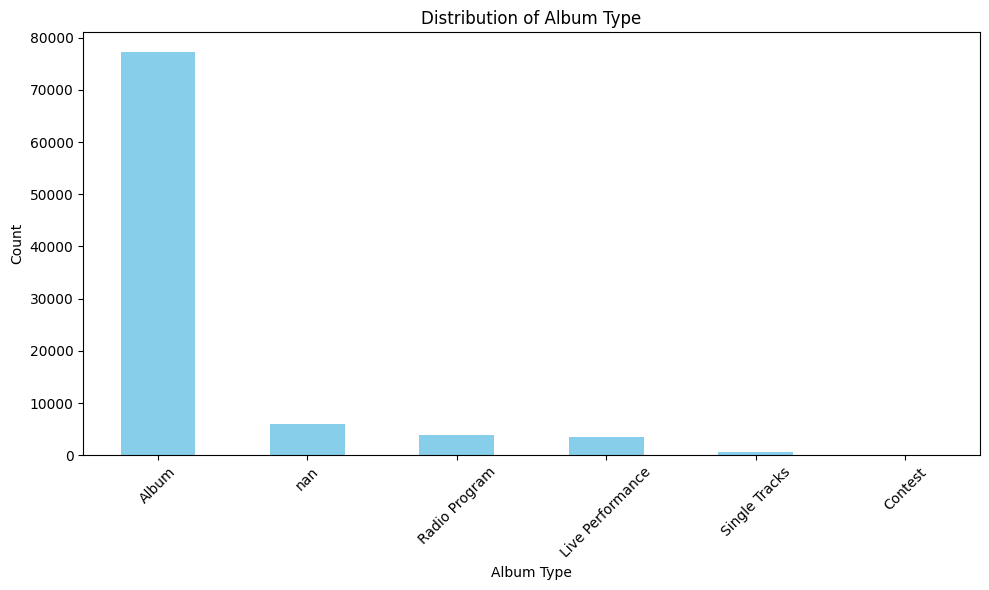

In [ ]:
plt.figure(figsize=(10,6))
merged['album_type'].value_counts(dropna=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Album Type')
plt.xlabel('Album Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Since the plot and the count shows high imbalance that cannot be recovered easily and can intoduce a bias, it is better to drop the column

In [ ]:
# drop the album_type col
merged.drop('album_type', axis=1, inplace=True)

In [ ]:
# drop the rest unrecovarable genre_top
merged.dropna(subset=['track_genre_top'], inplace=True)

#### UNSUPERVISED STEP

In [ ]:
# drop album type for unsuo as well
unsup.drop('album_type', axis=1, inplace=True)

# drop the rest unrecovarable genre_top
unsup.dropna(subset=['track_genre_top'], inplace=True)

### Encoding

- get target ready for encoding

In [ ]:
merged['track_genre_top'].value_counts()

track_genre_top
Electronic             21868
Experimental           19869
Rock                   17439
Pop                     6832
Folk                    4919
Instrumental            4182
Hip-Hop                 3923
International           2420
Jazz                    1909
Classical               1833
Blues                   1550
Soul-RnB                 841
Spoken                   626
Country                  544
Old-Time / Historic      344
Easy Listening           171
Name: count, dtype: int64

In [ ]:
# use label encoding

le = LabelEncoder()
y_genre_enc = le.fit_transform(merged['track_genre_top'])

# replace the categorical column with its encoding
merged['genre_top_en'] = y_genre_enc
# to show model's result you have to reverse this step(decoding)

# check mapping
print(dict(zip(le.classes_, le.transform(le.classes_))))


# use one-hot encoding when using linear models or NN -> not recommended with high dimensional data
# encoder = OneHotEncoder(sparse=False)
# y_onehot_enc_genre = encoder.fit_transform(tracks[['track_genre_top']]))

{'Blues': np.int64(0), 'Classical': np.int64(1), 'Country': np.int64(2), 'Easy Listening': np.int64(3), 'Electronic': np.int64(4), 'Experimental': np.int64(5), 'Folk': np.int64(6), 'Hip-Hop': np.int64(7), 'Instrumental': np.int64(8), 'International': np.int64(9), 'Jazz': np.int64(10), 'Old-Time / Historic': np.int64(11), 'Pop': np.int64(12), 'Rock': np.int64(13), 'Soul-RnB': np.int64(14), 'Spoken': np.int64(15)}


In [ ]:
merged['genre_top_en'].head(6)

0     7
1     7
2     7
3    12
4    12
5    12
Name: genre_top_en, dtype: int64

Now you can drop track_id as no further mapping nor merging will be applied - and any id related data

In [ ]:
# drop track_id
merged.drop('track_id', axis=1, inplace=True)

# look for any 'id' in the list of columns in merged and drop them
col_with_id = merged.columns[merged.columns.str.contains('id')]
merged.drop(col_with_id, axis=1, inplace=True)

#### UNSUPERVISED STEP

In [ ]:
# drop the track_id for unsup
unsup.drop('track_id', axis=1, inplace=True)

# look for any 'id' in the list of columns in merged and drop them
col_with_id = unsup.columns[unsup.columns.str.contains('id')]
unsup.drop(col_with_id, axis=1, inplace=True)

### Mutual Information

- It works by measuring how much knowing a feature reduces the target uncertinaty

- Does not assumes linearity, so it's a great statistical measurement to our rich data to apply feature selection before feature extraction!

- No scaling required! But it can help produce better results if the data is super unstable. See Bonus part

- It works for categorical and numerical data

In [ ]:
merged.isnull().sum()

album_comments        0
album_favorites       0
album_listens         0
album_tracks          0
artist_comments       0
                     ..
artist_profile_age    0
album_age             0
album_decade          0
track_age             0
genre_top_en          0
Length: 523, dtype: int64

In [ ]:
# exclude track_genre_top from merged

# keep the track_genre_top column in df called target with the encoding
# target = merged[['track_genre_top', 'genre_top_en']]
# target.head(2)

# drop it from merged
# labels = ['track_genre_top', 'genre_top_en']
# merged.drop(labels, axis=1, inplace=True)

### UNSUPERVISED STEP

In [ ]:
# drop it also from unsup
unsup.drop('track_genre_top', axis=1, inplace=True)

In [ ]:
# features
# X = merged.drop(columns=['genre_top_en', 'track_genre_top'], axis=1)
# this way merged['genre_top_en'] is not included freeing space for important features
cat_cols = merged.select_dtypes(include=['object']).columns
X = merged.drop(cat_cols, axis=1)
# target (label encoded)
y = merged['genre_top_en']

mi_scores = mutual_info_classif(X, y, discrete_features='auto')
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print(mi_series)

genre_top_en          2.111430
album_listens         1.736522
artist_favorites      0.305210
album_tracks          0.176261
artist_comments       0.124517
                        ...   
chroma_stft_max_11    0.001347
chroma_stft_max_04    0.001231
chroma_cqt_max_01     0.000551
chroma_stft_max_08    0.000000
chroma_stft_max_03    0.000000
Length: 522, dtype: float64


### MI results:

- MI always returns >= 0
- if closer to 0 then feature is irrelevant to target
- set a threshold and drop the rest that doesn't fit the threshold applied
- change the threshold in future after viewing model results, decide if to use a stricter threshold or a softer one

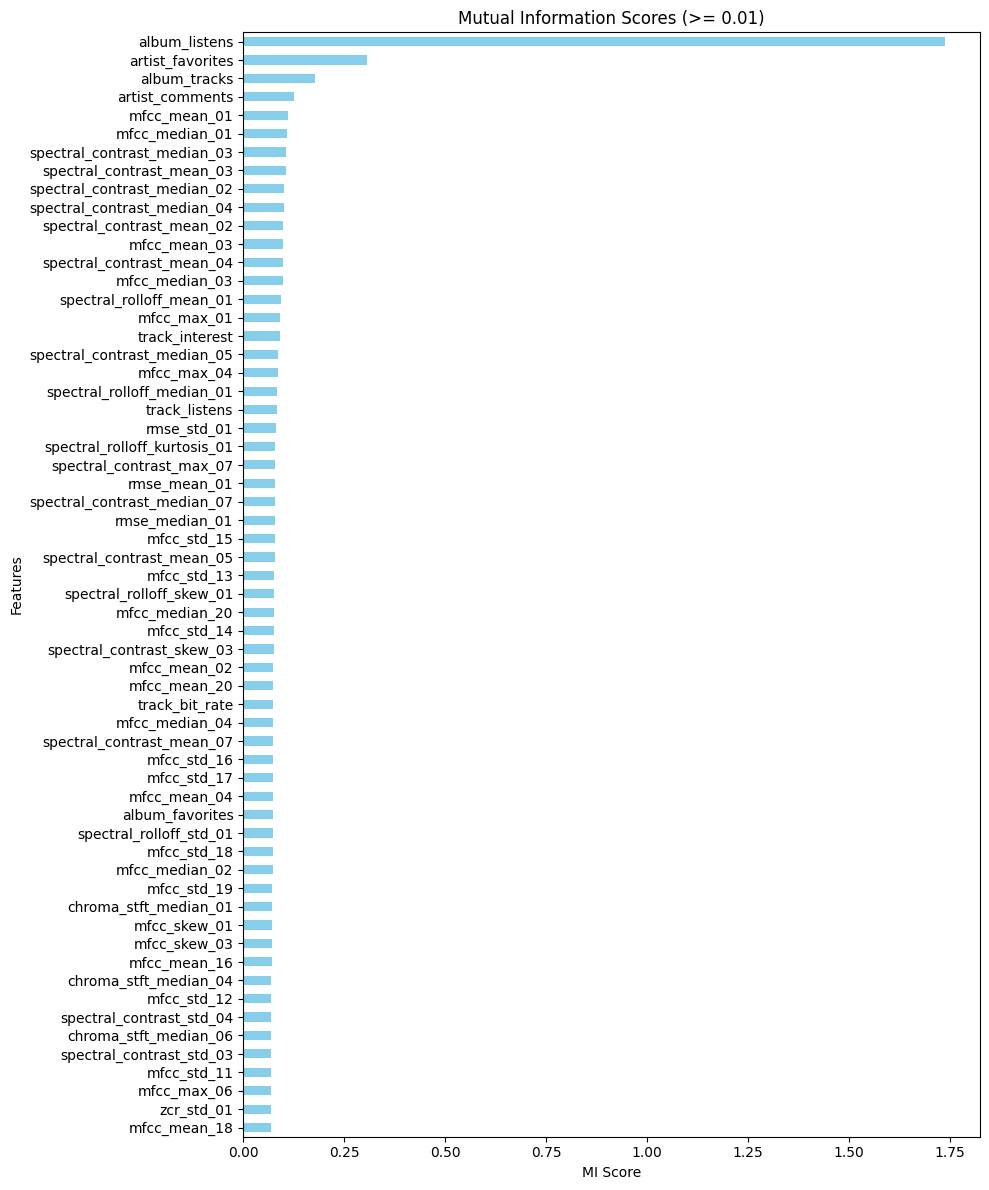

In [ ]:
# filter features above threshold
threshold = 0.01
mi_filtered = mi_series[mi_series >= threshold].sort_values(ascending=True)

# limit to top 50 since they are too many and the diagram is unclear
mi_top = mi_filtered.tail(60)

# plot horizontal bar chart
plt.figure(figsize=(10, 12))
mi_top.plot(kind='barh', color='skyblue')
plt.title("Mutual Information Scores (>= 0.01)")
plt.xlabel("MI Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [ ]:
print("Number of features before applying MI:", len(mi_series))
print("Number of features kept:", len(mi_filtered))

Number of features before applying MI: 521
Number of features kept: 493


In [ ]:
# drop irrelevant features discovered from MI

# 1. get the list of features to drop
mi_drop = mi_series[mi_series < threshold].sort_values(ascending=True)

# 2. drop
merged.drop(mi_drop.index, axis=1, inplace=True)

#### UNSUPERVISED STEP

In [ ]:
# drop features also from unsup
unsup.drop(mi_drop.index, axis=1, inplace=True)

In [ ]:
# apply MI for unsup then check dimesions and data shape before and after
# (since alot of dropping applied to the dataset)
unsup.shape

(89270, 494)

In [ ]:
merged.shape

(89270, 495)

### unsupervised step

In [ ]:
#select only numeric columns
numeric_cols = unsup.select_dtypes(include='number').columns

#calculate the missing ratio
nan_ratio = unsup[numeric_cols].isna().mean()

#keep only the columns with less then 40% missing values
keep_cols = nan_ratio[nan_ratio < 0.40].index

#create a clean copy of the selected columns
unsup_clean = unsup[keep_cols].copy()

#fill remaining missing values with the mean
unsup_clean = unsup_clean.fillna(unsup_clean.mean())

print("Shape of unsup_clean:", unsup_clean.shape)

Shape of unsup_clean: (58109, 494)


In [ ]:
# Initialize the scaler
scaler = StandardScaler()

#scale unsup
unsup_ss = scaler.fit_transform(unsup_clean)

In [ ]:
# for the HDBSCAN in UMAP
scaler = RobustScaler()

unsup_robust = scaler.fit_transform(unsup)

## split the data for supervised models

 We are going to compare three different preprocessing scenarios:

(1) no scaling, no LDA, no SMOTE

(2) with SMOTE only (to handle class imbalance)

(3) with SMOTE + LDA

following the correct pipeline to avoid data leakage


In [ ]:
# split the data into x and y (this common for the whole scenarios)
X = merged.drop(columns=["genre_top_en", "track_genre_top"])
y = merged["genre_top_en"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# scaling before smote - additional
# merged dataframe - apply scaling
# scaler = StandardScaler()
# X_train_ss = scaler.fit_transform(X_train)
# X_test_ss = scaler.fit_transform(X_test)
# you can use this scaled data on smote

# merged dataframe - smote
# X_train_sm, y_train_sm = smote.fit_resample(X_train_ss, y_train)

In [ ]:
# split for FNN
# using unsup

# identify X and Y
X_nn = unsup.drop(columns=['track_genre_top'], axis=1)
y_nn = merged['genre_top_en']

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.2,
                                                    random_state=42, stratify=y_nn)

# split X_train again to create validation set
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_nn, y_train_nn, test_size=0.25,
                                                  random_state=42, stratify=y_train_nn) # 0.25 x 0.8 = 0.2
# train = 60%, test = 20%, val = 20%

# apply scaling
scaler = StandardScaler()
X_train_nn_ss = scaler.fit_transform(X_train_nn)

# scale test and validation data
X_test_nn_ss = scaler.fit_transform(X_test_nn)
X_val_nn_ss = scaler.fit_transform(X_val_nn)

# apply LDA to both merged and unsup dataframes
# keep all possible components
lda = LDA(n_components=None)

# unsup dataframe
X_train_nn_lda = lda.fit_transform(X_train_nn_ss, y_train_nn)
X_val_nn_lda   = lda.fit_transform(X_val_nn_ss, y_val_nn)
X_test_nn_lda  = lda.fit_transform(X_test_nn_ss, y_test_nn)

print("Max LDA components:", X_train_nn_lda.shape[1])
# max lda component = classes - 1

# apply SMOTE oversampling
# create SMOTE object
k_neighbors = 4
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)

# apply SMOTE ONLY on training data - nn
X_train_nn_sm, y_train_nn_sm = smote.fit_resample(X_train_nn_ss, y_train_nn)

Max LDA components: 15


/home/momiji/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [ ]:
X_train.shape

(71416, 491)

In [ ]:
X.columns

Index(['album_comments', 'album_favorites', 'album_listens', 'album_tracks',
       'artist_comments', 'artist_favorites', 'track_bit_rate',
       'track_duration', 'track_favorites', 'track_interest',
       ...
       'zcr_max_01', 'zcr_mean_01', 'zcr_median_01', 'zcr_min_01',
       'zcr_skew_01', 'zcr_std_01', 'artist_profile_age', 'album_age',
       'album_decade', 'track_age'],
      dtype='object', length=491)

In [ ]:
# for the first scenario
X_train_raw = X_train
X_test_raw  = X_test
y_train_raw = y_train
y_test_raw  = y_test

In [ ]:
# for the second scenario
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# to avoid data leakage
X_test_sm = X_test
y_test_sm = y_test

In [ ]:
# for the third scenario

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

lda = LDA(n_components=None)
X_train_lda = lda.fit_transform(X_train_sm, y_train_sm)
X_test_lda = lda.transform(X_test)

## ---------------------------------------------------------
##  **🧠 Modeling Step: Build and Train the Models**
## ---------------------------------------------------------



In [ ]:
# Saving & Loading Utilities
# These functions let us save models into Google Drive
# to protect our work from session resets and to reload things easily
####### layal - hatoon - abeer - bashayer, see this one and use it when you train ur models #######
def _path(name, ext):
    return os.path.join(PROJECT_DIR, f"{name}.{ext}")

def save_model(model, name):
    with open(_path(name, "pkl"), "wb") as f:
        pickle.dump(model, f)
    print(f"model saved to: {_path(name, 'pkl')}")

def load_model(name):
    with open(_path(name, "pkl"), "rb") as f:
        model = pickle.load(f)
    print(f"model loaded from: {_path(name, 'pkl')}")
    return model

### **supervised models**
##### **let the models learn from the data**


1) Random Forest

In [ ]:
# first scenario
rf_raw = RandomForestClassifier(
  n_estimators=400,
  max_depth=20,
  min_samples_split=4,
  n_jobs=-1,
  random_state=42,
  class_weight='balanced'
)

rf_raw.fit(X_train_raw, y_train_raw)

#save the model
save_model(rf_raw, "rf_raw_model")

model saved to: /content/drive/MyDrive/Our_Project/rf_raw_model.pkl


In [ ]:
# second scenario
rf_smote = RandomForestClassifier(
   n_estimators=400,
   max_depth=20,
   min_samples_split=4,
   n_jobs=-1,
   random_state=42,
   class_weight='balanced'
)
rf_smote.fit(X_train_sm, y_train_sm)

#save the model
save_model(rf_smote, "rf_smote_model")

model saved to: /content/drive/MyDrive/Our_Project/rf_smote_model.pkl


In [ ]:
# third scenario
rf_lda = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    min_samples_split=4,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)
rf_lda.fit(X_train_lda, y_train_sm)

#save the model
save_model(rf_lda, "rf_lda_model")

model saved to: /content/drive/MyDrive/Our_Project/rf_lda_model.pkl


2-catboost

In [ ]:
# weights for raw data (scenario 1)
classes_raw = np.unique(y_train_raw)
class_weights_raw = compute_class_weight(
    class_weight='balanced',
    classes=classes_raw,
    y=y_train_raw
)
class_weights_raw_dict = {cls: w for cls, w in zip(classes_raw, class_weights_raw)}

# weights for SMOTE data (scenarios 2 & 3)
classes_sm = np.unique(y_train_sm)
class_weights_sm = compute_class_weight(
    class_weight='balanced',
    classes=classes_sm,
    y=y_train_sm
)
class_weights_sm_dict = {cls: w for cls, w in zip(classes_sm, class_weights_sm)}


In [ ]:
# firts scenario
cb_raw = CatBoostClassifier(iterations=400, learning_rate=0.1, depth=6, random_state=42, verbose=50, class_weights=class_weights_raw_dict)
cb_raw.fit(X_train_raw, y_train_raw, eval_set=(X_test_raw, y_test_raw), use_best_model=True)
# save the model
save_model(cb_raw, "catboost_raw")

0:	learn: 2.6709735	test: 2.6713988	best: 2.6713988 (0)	total: 1.2s	remaining: 8m
50:	learn: 1.6479240	test: 1.7764845	best: 1.7764845 (50)	total: 1m 1s	remaining: 6m 59s
100:	learn: 1.3573219	test: 1.5737505	best: 1.5737505 (100)	total: 2m	remaining: 5m 56s
150:	learn: 1.1395238	test: 1.3897030	best: 1.3897030 (150)	total: 2m 58s	remaining: 4m 54s
200:	learn: 0.9940128	test: 1.2730181	best: 1.2730181 (200)	total: 3m 56s	remaining: 3m 54s
250:	learn: 0.9072448	test: 1.2053425	best: 1.2053425 (250)	total: 4m 54s	remaining: 2m 54s
300:	learn: 0.8335575	test: 1.1581234	best: 1.1577935 (298)	total: 5m 52s	remaining: 1m 55s
350:	learn: 0.7734843	test: 1.1183649	best: 1.1183649 (350)	total: 6m 50s	remaining: 57.2s
399:	learn: 0.7265261	test: 1.0859672	best: 1.0856017 (398)	total: 7m 46s	remaining: 0us

bestTest = 1.085601692
bestIteration = 398

Shrink model to first 399 iterations.
model saved to: /content/drive/MyDrive/Our_Project/catboost_raw.pkl


In [ ]:
# second scenario
cb_sm = CatBoostClassifier(iterations=400, learning_rate=0.1, depth=6, random_state=42, verbose=50, class_weights=class_weights_sm_dict)
cb_sm.fit(X_train_sm, y_train_sm, eval_set=(X_test_sm, y_test_sm), use_best_model=True)
# save the model
save_model(cb_sm, "catboost_sm")

0:	learn: 2.6200565	test: 2.7037918	best: 2.7037918 (0)	total: 3.97s	remaining: 26m 22s
50:	learn: 1.4517832	test: 1.8511694	best: 1.8511694 (50)	total: 3m 26s	remaining: 23m 29s
100:	learn: 1.1559170	test: 1.6120485	best: 1.6120485 (100)	total: 6m 47s	remaining: 20m 6s
150:	learn: 0.9623271	test: 1.4588234	best: 1.4588234 (150)	total: 10m 7s	remaining: 16m 42s
200:	learn: 0.8359203	test: 1.3546680	best: 1.3546680 (200)	total: 13m 28s	remaining: 13m 20s
250:	learn: 0.7374275	test: 1.2739455	best: 1.2739455 (250)	total: 16m 48s	remaining: 9m 58s
300:	learn: 0.6641782	test: 1.2154097	best: 1.2154097 (300)	total: 20m 8s	remaining: 6m 37s
350:	learn: 0.6127585	test: 1.1746747	best: 1.1746747 (350)	total: 23m 28s	remaining: 3m 16s
399:	learn: 0.5621311	test: 1.1340983	best: 1.1340983 (399)	total: 26m 44s	remaining: 0us

bestTest = 1.134098261
bestIteration = 399

model saved to: /content/drive/MyDrive/Our_Project/catboost_sm.pkl


In [ ]:
# third scenario
cb_lda = CatBoostClassifier(iterations=400, learning_rate=0.1, depth=6, random_state=42, verbose=50, class_weights=class_weights_sm_dict)
cb_lda.fit(X_train_lda, y_train_sm, eval_set=(X_test_lda, y_test_sm), use_best_model=True)
# save the model
save_model(cb_lda, "catboost_lda")

0:	learn: 2.5045474	test: 2.6681220	best: 2.6681220 (0)	total: 212ms	remaining: 1m 24s
50:	learn: 1.3747862	test: 1.9232026	best: 1.9232026 (50)	total: 10.8s	remaining: 1m 13s
100:	learn: 1.2448784	test: 1.8469821	best: 1.8469821 (100)	total: 21.4s	remaining: 1m 3s
150:	learn: 1.1813094	test: 1.8161102	best: 1.8161102 (150)	total: 32s	remaining: 52.8s
200:	learn: 1.1351377	test: 1.7986348	best: 1.7986348 (200)	total: 42.3s	remaining: 41.9s
250:	learn: 1.0931066	test: 1.7837347	best: 1.7837347 (250)	total: 52.9s	remaining: 31.4s
300:	learn: 1.0595140	test: 1.7729306	best: 1.7729306 (300)	total: 1m 3s	remaining: 20.9s
350:	learn: 1.0285234	test: 1.7631952	best: 1.7631952 (350)	total: 1m 14s	remaining: 10.3s
399:	learn: 0.9988371	test: 1.7547608	best: 1.7547608 (399)	total: 1m 24s	remaining: 0us

bestTest = 1.754760815
bestIteration = 399

model saved to: /content/drive/MyDrive/Our_Project/catboost_lda.pkl


3) XGBoost

In [ ]:
# base model
xgb_base = XGBClassifier(random_state=42, n_jobs=-1)

# parameter grid to search
param_grid = {
    "n_estimators": [200],
    "max_depth": [4, 6],
    "learning_rate": [0.1],
    "subsample": [1.0],
    "colsample_bytree": [1.0]}

# grid search with 3-fold CV
xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1)

xgb_grid.fit(X_train_sm, y_train_sm)
print("Best params:", xgb_grid.best_params_)
print("Best CV accuracy:", xgb_grid.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
Best CV accuracy: 0.8815197520017256


In [ ]:
# best parameters from GridSearch
best_params = xgb_grid.best_params_

In [ ]:
# first scsnario
xgb_raw = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)
xgb_raw.fit(X_train_raw, y_train_raw)

# save the model
save_model(xgb_raw, "xgb_raw_model")

model saved to: /content/drive/MyDrive/Our_Project/xgb_raw_model.pkl


In [ ]:
# second scenario
xgb_smote = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)
xgb_smote.fit(X_train_sm, y_train_sm)

# save the model
save_model(xgb_smote, "xgb_smote_model")

model saved to: /content/drive/MyDrive/Our_Project/xgb_smote_model.pkl


In [ ]:
# third scenario
xgb_lda = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)


xgb_lda.fit(X_train_lda, y_train_sm)

# save the model
save_model(xgb_lda , "xgb_lda _model")

model saved to: /content/drive/MyDrive/Our_Project/xgb_lda _model.pkl


4. FNN

/home/momiji/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │        63,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,832 (323.56 KB)

 Trainable params: 82,320 (321.56 KB)

 Non-trainable params: 512 (2.00 KB)

None
Scenario 1: FNN with L2 regularization
Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1139 - loss: 3.1125 - val_accuracy: 0.2644 - val_loss: 2.3051
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1947 - loss: 2.2930 - val_accuracy: 0.2809 - val_loss: 2.2212
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2295 - loss: 2.1354 - val_accuracy: 0.2926 - val_loss: 2.1540
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2549 - loss: 1.9515 - val_accuracy: 0.2948 - val_loss: 2.1150
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2587 - loss: 1.8969 - val_accuracy: 0.3268 - val_loss: 2.0382
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2742 - loss: 1.8257 - val_accuracy: 0.3337 - val_loss: 2.0111
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2946 - loss: 1.7982 - val_accuracy: 0.3357 - val_loss: 1.9940
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accura

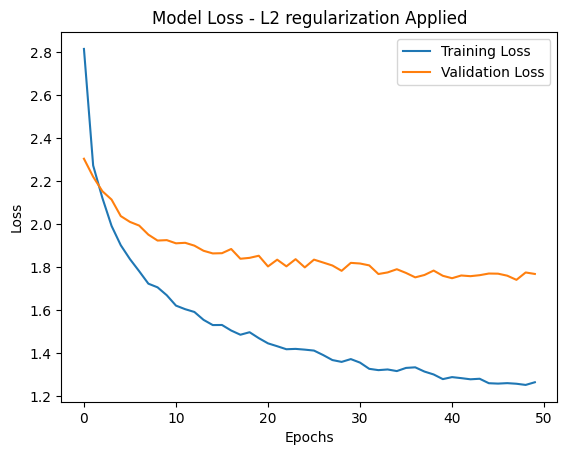

In [ ]:
# Scenario 1

# use class weigths when fitting the model
classes = np.unique(y_train_nn)
cw = compute_class_weight('balanced', classes=classes, y=y_train_nn)
class_weights = dict(zip(classes, cw))

# model hyperparameters
epochs = 50
batch_size = 256
lr = 1e-3
input_shape = X_train_nn_ss.shape[1],

# create model
model_with_l2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape,
                 kernel_regularizer=regularizers.l2(1e-4)), #penality
    layers.BatchNormalization(), #normalize before next layer
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(16, activation='softmax')
])

# print model summery
print(model_with_l2.summary())

# to avoid overfitting, lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model_with_l2.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# print statement to indicate the scenario
print("Scenario 1: FNN with L2 regularization")

# train on train_ss
model_with_l2.fit(X_train_nn_ss, y_train_nn,
          validation_data=(X_val_nn_ss, y_val_nn),
          class_weight=class_weights,
          batch_size=batch_size,
          epochs=epochs)

# save model
# save_model(model_with_l2, "fnn_l2_model")
# a note to my team: I cannot save models on the same path due to run conflict
# (I use my own environment to run the code on my GPU)

# plot losses
loss_df = pd.DataFrame(model_with_l2.history.history)
plt.plot(loss_df['loss'], label='Training Loss')
plt.plot(loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss - L2 regularization Applied')
plt.legend()
plt.show()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │        63,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,832 (323.56 KB)

 Trainable params: 82,320 (321.56 KB)

 Non-trainable params: 512 (2.00 KB)

None
Scenario 2: FNN with SMOTE
Epoch 1/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3880 - loss: 2.0981 - val_accuracy: 0.4071 - val_loss: 1.7789
Epoch 2/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6034 - loss: 1.2757 - val_accuracy: 0.4399 - val_loss: 1.6679
Epoch 3/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6530 - loss: 1.1112 - val_accuracy: 0.4462 - val_loss: 1.6356
Epoch 4/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6807 - loss: 1.0146 - val_accuracy: 0.4601 - val_loss: 1.6223
Epoch 5/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6957 - loss: 0.9713 - val_accuracy: 0.4841 - val_loss: 1.5692
Epoch 6/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7036 - loss: 0.9465 - val_accuracy: 0.4933 - val_loss: 1.5494
Epoch 7/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7165 - loss: 0.9103 - val_accuracy: 0.4874 - val_loss: 1.5560
Epoch 8/50
821/821 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7235 -

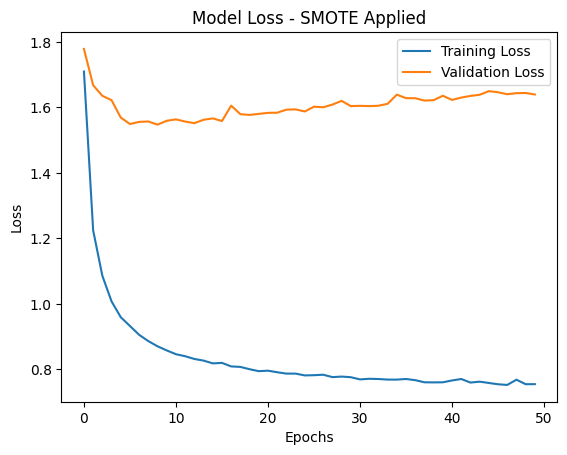

In [ ]:
# Scenario 2
# SMOTE oversampling for class imbalance

# hyperparameter
input_shape = X_train_nn_sm.shape[1],
epochs = 50
batch_size = 256
learning_rate = 1e-3
# k_neighbors
k_neighbors = 4

# create model
model_with_smote = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape,
                 kernel_regularizer=regularizers.l2(1e-4)), #penality
    layers.BatchNormalization(), #normalize before next layer
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(16, activation='softmax')
])

# print model summery
print(model_with_smote.summary())

# optimize
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# compile model
model_with_smote.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# print statement to indicate the scenario
print("Scenario 2: FNN with SMOTE")

# train with SMOTE
model_with_smote.fit(X_train_nn_sm, y_train_nn_sm,
          validation_data=(X_val_nn_ss, y_val_nn),
          batch_size=batch_size,
          epochs=epochs)

# save model
# save_model(model_with_smote, "fnn_smote_model")

# plot losses
loss_df = pd.DataFrame(model_with_smote.history.history)
plt.plot(loss_df['loss'], label='Training Loss')
plt.plot(loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss - SMOTE Applied')
plt.legend()
plt.show()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,648 (84.56 KB)

 Trainable params: 21,136 (82.56 KB)

 Non-trainable params: 512 (2.00 KB)

None
Scenario 3: FNN with LDA
Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1751 - loss: 2.8068 - val_accuracy: 0.1255 - val_loss: 2.7692
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2921 - loss: 2.0498 - val_accuracy: 0.1332 - val_loss: 2.8946
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3217 - loss: 1.8836 - val_accuracy: 0.1313 - val_loss: 2.8782
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3297 - loss: 1.7900 - val_accuracy: 0.1325 - val_loss: 2.8547
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3424 - loss: 1.7371 - val_accuracy: 0.1352 - val_loss: 2.8080
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3414 - loss: 1.7241 - val_accuracy: 0.1353 - val_loss: 2.7822
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3500 - loss: 1.6957 - val_accuracy: 0.1340 - val_loss: 2.7892
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3493 - l

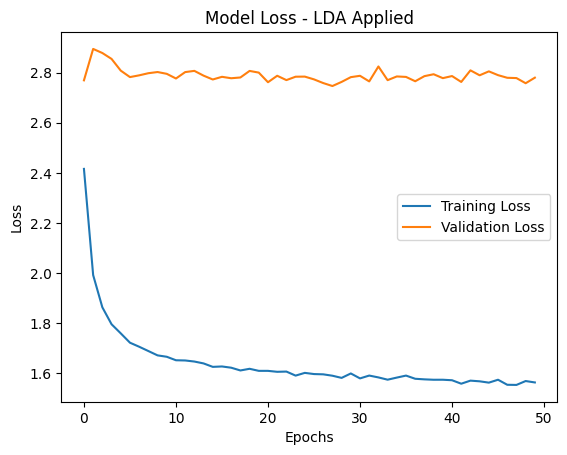

In [ ]:
# Scenario 3
# hyperparameter
learning_rate = 1e-3
epochs = 50
batch_size = 256

shape = X_train_nn_lda.shape[1],

# define model and new input shape (lda)
model_with_lda = Sequential([
    layers.Input(shape=shape),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(16, activation='softmax')
])

# print model summery
print(model_with_lda.summary())

# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# compile model
model_with_lda.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# print statement to indicate the scenario
print("Scenario 3: FNN with LDA")

# train model
model_with_lda.fit(
    X_train_nn_lda, y_train_nn,
    validation_data=(X_val_nn_lda, y_val_nn),
    class_weight=class_weights,
    batch_size=batch_size,
    epochs=epochs)

# save model
# save_model(model_with_lda, 'fnn_lda_model')

# plot losses
loss_df = pd.DataFrame(model_with_lda.history.history)
plt.plot(loss_df['loss'], label='Training Loss')
plt.plot(loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss - LDA Applied')
plt.legend()
plt.show()

1. random forest (Prediction)

In [ ]:
rf_raw

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=4, n_estimators=400, n_jobs=-1,
                       random_state=42)

In [ ]:
# prediction for the first scenario
y_pred_rf_raw_train = rf_raw.predict(X_train_raw)
y_pred_rf_raw_test  = rf_raw.predict(X_test_raw)

In [ ]:
# prediction for the second scenario
y_pred_rf_sm_train = rf_smote.predict(X_train_sm)
y_pred_rf_sm_test  = rf_smote.predict(X_test_sm)

In [ ]:
# prediction for the third scenario
y_pred_rf_lda_train = rf_lda.predict(X_train_lda)
y_pred_rf_lda_test  = rf_lda.predict(X_test_lda)

2. CatBoost (Prediction)

In [ ]:
# prediction for the first scenario
y_pred_cb_raw_train = cb_raw.predict(X_train_raw)
y_pred_cb_raw_test  = cb_raw.predict(X_test_raw)

In [ ]:
# prediction for the second scenario
y_pred_cb_sm_train = cb_sm.predict(X_train_sm)
y_pred_cb_sm_test  = cb_sm.predict(X_test_sm)

In [ ]:
# prediction for the third scenario
y_pred_cb_lda_train = cb_lda.predict(X_train_lda)
y_pred_cb_lda_test  = cb_lda.predict(X_test_lda)

3. XGBoost (Prediction)

In [ ]:
# prediction for the first scenario
y_pred_xgb_raw_train = xgb_raw.predict(X_train_raw)
y_pred_xgb_raw_test  = xgb_raw.predict(X_test_raw)

In [ ]:
# prediction for the second scenario
y_pred_xgb_sm_train = xgb_smote.predict(X_train_sm)
y_pred_xgb_sm_test  = xgb_smote.predict(X_test_sm)

In [ ]:
# prediction for the third scenario
y_pred_xgb_lda_train = xgb_lda.predict(X_train_lda)
y_pred_xgb_lda_test  = xgb_lda.predict(X_test_lda)

4. FNN (Prediction)

In [ ]:
# S1 - prediction with L2 model on scaled data

# on train
y_train_pred_l2 = model_with_l2.predict(X_train_nn_ss)

# on test
y_pred_fnn_l2 = model_with_l2.predict(X_test_nn_ss)

# S2 - prediction with smote applied model on sm data

# on train
y_train_pred_sm = model_with_smote.predict(X_train_nn_sm)

# on test
y_pred_fnn_sm = model_with_smote.predict(X_test_nn_ss)

# S3 - prediction with lda applied model on lda

# on train
y_train_pred_lda = model_with_lda.predict(X_train_nn_lda)

# on test
y_pred_fnn_lda = model_with_lda.predict(X_test_nn_lda)

1674/1674 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
6561/6561 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
558/558 ━━━━━━━━━━━━━━━━━━━━ -0s -61us/step
1674/1674 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


### **unsupervised models**
##### **let the models learn from the data**


we going to implement Kmeans using:

1- scaling + UMAP for kMeans model .

In [ ]:
#UMAP for Kmean clustering only.
kmean_umap = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

#fit the umap model with scaled unsup
k_umap = kmean_umap.fit_transform(unsup_ss)
#display the shape of the new dimensionds.
print("UMAP shape :",k_umap.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape : (58109, 2)


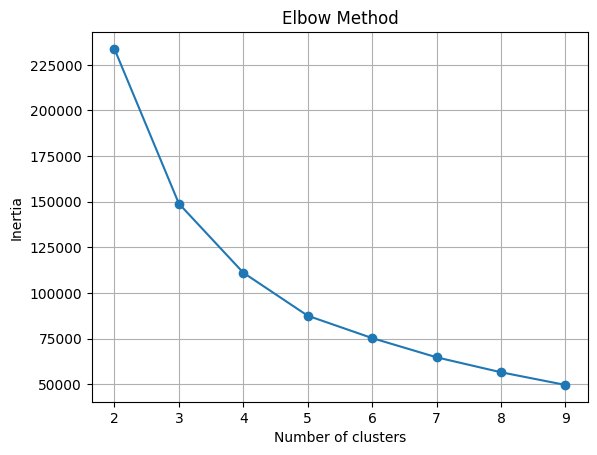

In [ ]:
#UMAP for Kmean clustering only.
kmean_umap = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

#fit the umap model with scaled unsup
k_umap = kmean_umap.fit_transform(unsup_ss)
#display the shape of the new dimensionds.
print("UMAP shape :",k_umap.shape)

In [ ]:
#Train K-means model with k = 3
kmeans = KMeans(n_clusters= 3, random_state=42, n_init=100)
km_labels = kmeans.fit_predict(k_umap)

we going to implement MULTI STAGE CLUSTRING using:

1-scaling + UMAP for multi stage clustering.
(1) HDBSCAN main clusters then (2) KMeans subclustering inside each main cluster.

In [ ]:
#UMAP for Multi stage clustering(HDBSCAN + KMEAN) MODEL AND HDBSCAN MODEL.
multi_umap= umap.UMAP(
    n_neighbors=45,
    n_components=15,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

#fit the umap model with scaled unsup
m_umap = multi_umap.fit_transform(unsup_ss)
#display the shape of the new dimensionds.
print("UMAP shape:", m_umap.shape)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP shape: (58109, 15)


In [ ]:
#implement HDBSCAN MODEL
hd = hdbscan.HDBSCAN(ابغا
    min_cluster_size=45,
    min_samples=10,
    metric='euclidean',
    cluster_selection_method='leaf'
)

#fit the HDBSCAN on UMAP and get the cluster label for each point.
#the point that labeled (-1) are considered outliers.
label_level1 = hd.fit_predict(m_umap)

#get all unique IDs except outliers.
clusters_level1 = [cluster for cluster in np.unique(label_level1) if cluster != -1]


#display the number of points belong to each cluster.
print("\nCluster sizes:")
for cluster in clusters_level1:
    count = np.sum(label_level1 == cluster)
    print(f"Cluster {cluster}: {count} points")

#display the number of points labeled as outlier.
print("Noise points:", np.sum(label_level1 == -1))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Cluster sizes:
Cluster 0: 209 points
Cluster 1: 106 points
Cluster 2: 45 points
Cluster 3: 128 points
Cluster 4: 46 points
Cluster 5: 79 points
Cluster 6: 45 points
Cluster 7: 87 points
Cluster 8: 87 points
Cluster 9: 66 points
Cluster 10: 92 points
Cluster 11: 60 points
Cluster 12: 199 points
Cluster 13: 190 points
Cluster 14: 210 points
Cluster 15: 91 points
Cluster 16: 122 points
Cluster 17: 91 points
Cluster 18: 56 points
Cluster 19: 196 points
Cluster 20: 69 points
Cluster 21: 108 points
Cluster 22: 45 points
Cluster 23: 224 points
Cluster 24: 95 points
Cluster 25: 61 points
Cluster 26: 82 points
Cluster 27: 50 points
Cluster 28: 71 points
Cluster 29: 185 points
Cluster 30: 183 points
Cluster 31: 81 points
Cluster 32: 104 points
Cluster 33: 181 points
Cluster 34: 192 points
Cluster 35: 139 points
Cluster 36: 138 points
Cluster 37: 132 points
Cluster 38: 47 points
Cluster 39: 73 points
Cluster 40: 83 points
Cluster 41: 58 points
Cluster 42: 146 points
Cluster 43: 82 points
Cluster

In [ ]:
#create a dictionary to determaine the number of subclusters inside each main cluster.
sub_k = {cluster: 2 for cluster in clusters_level1}

#create an array with the same length as number of data points.
#and fill it with -1 to replace it with the cluster number.
final_labels = np.full_like(label_level1, -1)

offset = 0

#loop for each main cluster that found by HDBSCAN MODEL
for cluster in clusters_level1:
    mask = (label_level1 == cluster)  #create a boolean matrix to select only the points that belong to the cluster.
    X_cluster = m_umap[mask]  #to get UMAP points inside this cluster.
    k = sub_k[cluster]  #to get the number of subclusters defined for this cluster


#fit KMEAN MODEL with number of subclusters on each main clusters
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    sub_labels = km.fit_predict(X_cluster)

    #assign the subcluster labels to the final labels array
    final_labels[mask] = sub_labels + offset
    offset += k #update offset for the next cluster to ensure unique cluster IDs accross all subclusters


  #to get only the points that are assigned to clusters, without outliars.
valid_mask = (final_labels != -1)

#display the final clusters IDs.
print("Number of clusters:", np.unique(final_labels[valid_mask]))

Number of clusters: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159]


2.HDBSCAN

UMAP + HDBSCAN

In [ ]:
data_umap = umap.UMAP(n_neighbors=100,
                      min_dist=0.01,
                      n_components=20,
                      metric='cosine',
                      random_state=42)

X_umap_hdbscan = data_umap.fit_transform(unsup_robust)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
X = X_umap_hdbscan
y = np.array(y_genre_enc)
y = y[:len(X)]

print("X:", X.shape)
print("y:", y.shape)

X: (58109, 20)
y: (58109,)


In [ ]:
hdbscann = hdbscan.HDBSCAN(min_cluster_size=60,
                           min_samples=10,
                           metric='euclidean',
                           cluster_selection_method='eom')

y_pred = hdbscann.fit_predict(X)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
not_noise = y_pred != -1
noise = (y_pred == -1).sum()# -1 for noises
num_clusters = len(np.unique(y_pred[y_pred != -1]))

print("noise points:", noise)
print("Number of clusters:", num_clusters)

noise points: 30077
Number of clusters: 45


## ---------------------------------------------------------
##  **🧪  Evaluation Step: Assess Models Performance**
## ---------------------------------------------------------


### **supervised models**
##### **evaluate the performance of the models**

In [ ]:
label_encoder = le

In [ ]:
def evaluate_model(name, y_true_train, y_pred_train, y_true_test, y_pred_test, label_encoder):
    print(f"\n===== {name} =====")

    # Train performance
    print("\ntrain performance:")
    print("accuracy:", accuracy_score(y_true_train, y_pred_train))
    print("macro F1:", f1_score(y_true_train, y_pred_train, average='macro'))

    # Test performance
    print("\ntest performance:")
    print("accuracy:", accuracy_score(y_true_test, y_pred_test))
    print("macro F1:", f1_score(y_true_test, y_pred_test, average='macro'))

    # Classification report
    print("\nclassification report (test):")
    print(classification_report(
        y_true_test,
        y_pred_test,
        target_names=label_encoder.classes_
    ))
    # Confusion matrix
    cm = confusion_matrix(
        y_true_test,
        y_pred_test,
        labels=range(len(label_encoder.classes_))
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=False,
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


1. Random Forest


===== Random Forest RAW =====

train performance:
accuracy: 0.9847513162316568
macro F1: 0.9910132343851877

test performance:
accuracy: 0.5342220230760614
macro F1: 0.4135615451189435

classification report (test):
                     precision    recall  f1-score   support

              Blues       0.94      0.42      0.58       310
          Classical       0.76      0.60      0.67       367
            Country       0.88      0.13      0.22       109
     Easy Listening       0.00      0.00      0.00        34
         Electronic       0.51      0.64      0.57      4373
       Experimental       0.51      0.65      0.57      3974
               Folk       0.45      0.47      0.46       984
            Hip-Hop       0.67      0.39      0.50       785
       Instrumental       0.48      0.37      0.42       836
      International       0.80      0.21      0.34       484
               Jazz       0.75      0.14      0.23       382
Old-Time / Historic       0.94      0.72      0.82

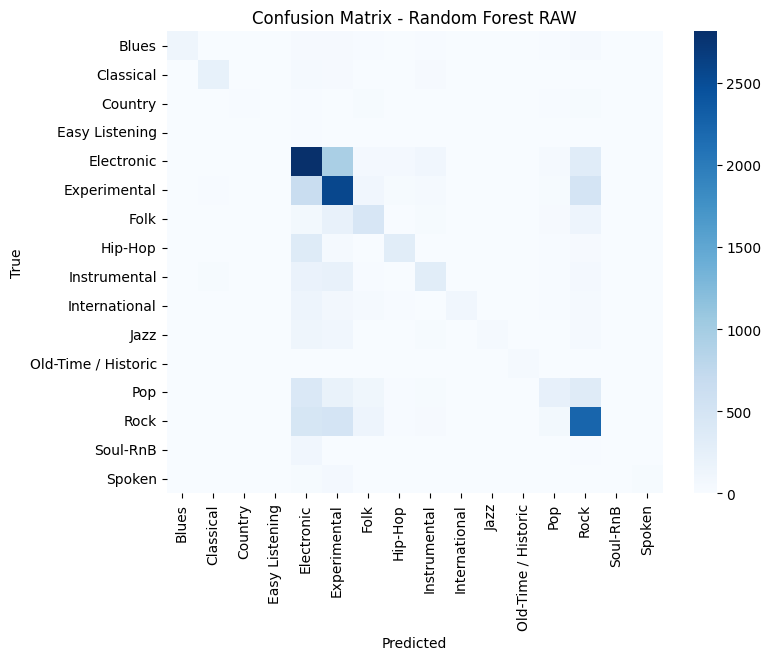

In [ ]:
# first scenario evaluation
evaluate_model("Random Forest RAW", y_train_raw, y_pred_rf_raw_train, y_test_raw, y_pred_rf_raw_test,label_encoder)


===== Random Forest SMOTE =====

train performance:
accuracy: 0.998313803943984
macro F1: 0.998314655259269

test performance:
accuracy: 0.5465441917777529
macro F1: 0.547716916714549

classification report (test):
                     precision    recall  f1-score   support

              Blues       0.86      0.56      0.68       310
          Classical       0.61      0.73      0.67       367
            Country       0.89      0.57      0.69       109
     Easy Listening       0.80      0.24      0.36        34
         Electronic       0.62      0.50      0.55      4373
       Experimental       0.57      0.59      0.58      3974
               Folk       0.39      0.59      0.47       984
            Hip-Hop       0.42      0.63      0.50       785
       Instrumental       0.36      0.56      0.44       836
      International       0.55      0.47      0.51       484
               Jazz       0.45      0.43      0.44       382
Old-Time / Historic       0.85      0.87      0.86 

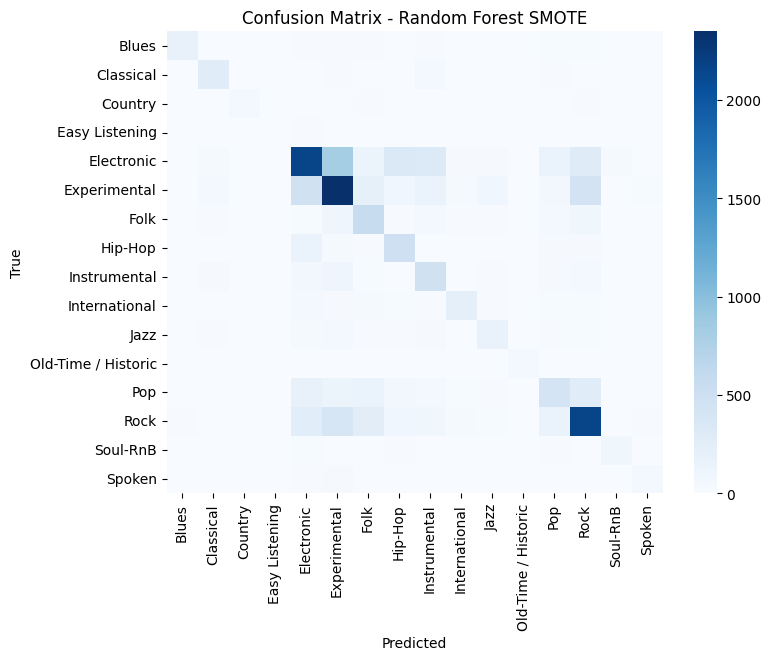

In [ ]:
# second scenario evaluation
evaluate_model("Random Forest SMOTE", y_train_sm, y_pred_rf_sm_train, y_test_sm, y_pred_rf_sm_test, label_encoder)


===== Random Forest SMOTE and LDA =====

train performance:
accuracy: 0.9694091168905401
macro F1: 0.9693088238119175

test performance:
accuracy: 0.4411336395205556
macro F1: 0.3591072489163514

classification report (test):
                     precision    recall  f1-score   support

              Blues       0.36      0.45      0.40       310
          Classical       0.42      0.64      0.51       367
            Country       0.16      0.43      0.24       109
     Easy Listening       0.04      0.15      0.06        34
         Electronic       0.60      0.43      0.50      4373
       Experimental       0.55      0.44      0.49      3974
               Folk       0.33      0.45      0.38       984
            Hip-Hop       0.35      0.59      0.44       785
       Instrumental       0.25      0.40      0.30       836
      International       0.24      0.37      0.29       484
               Jazz       0.19      0.41      0.26       382
Old-Time / Historic       0.49      0.83

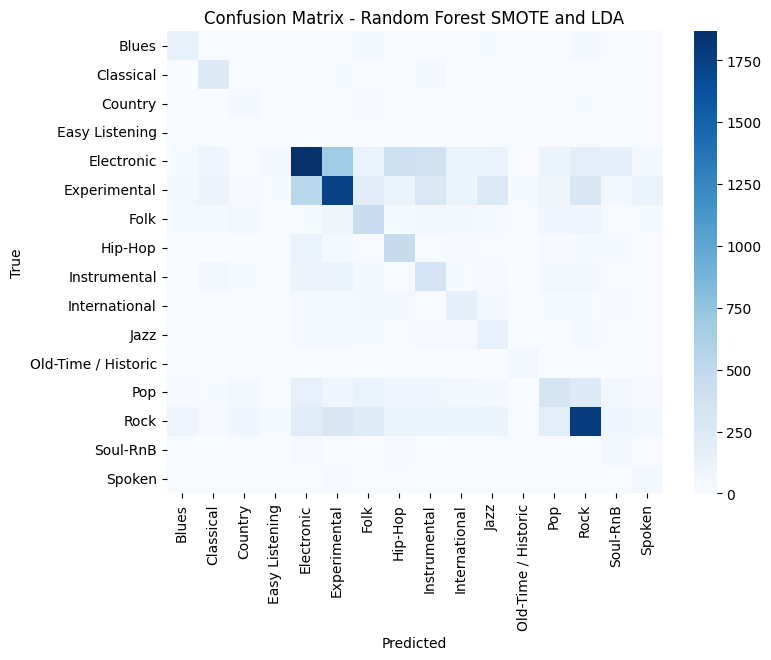

In [ ]:
# third scenario evaluation
evaluate_model("Random Forest SMOTE and LDA", y_train_sm, y_pred_rf_lda_train, y_test_sm, y_pred_rf_lda_test, label_encoder)

2. CatBoost


===== CatBoost RAW =====

train performance:
accuracy: 0.6252800492886748
macro F1: 0.6618852238987618

test performance:
accuracy: 0.5654755236921698
macro F1: 0.5600995602291499

classification report (test):
                     precision    recall  f1-score   support

              Blues       0.55      0.71      0.62       310
          Classical       0.56      0.85      0.67       367
            Country       0.40      0.83      0.54       109
     Easy Listening       0.53      0.56      0.54        34
         Electronic       0.74      0.48      0.58      4373
       Experimental       0.68      0.54      0.60      3974
               Folk       0.40      0.60      0.48       984
            Hip-Hop       0.44      0.80      0.56       785
       Instrumental       0.44      0.68      0.53       836
      International       0.36      0.60      0.45       484
               Jazz       0.33      0.71      0.45       382
Old-Time / Historic       0.82      0.93      0.87     

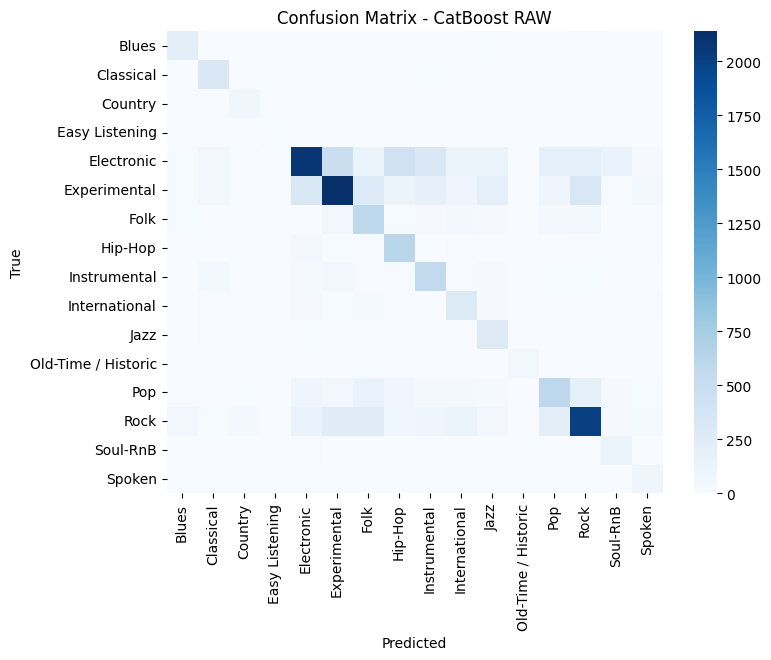

In [ ]:
# first scenario evaluation
evaluate_model("CatBoost RAW", y_train_raw, y_pred_cb_raw_train, y_test_raw, y_pred_cb_raw_test, label_encoder)


===== CatBoost SMOTE =====

train performance:
accuracy: 0.8593776793369534
macro F1: 0.8569677757568921

test performance:
accuracy: 0.6251820320376387
macro F1: 0.6307128818085511

classification report (test):
                     precision    recall  f1-score   support

              Blues       0.74      0.68      0.71       310
          Classical       0.65      0.83      0.73       367
            Country       0.58      0.79      0.67       109
     Easy Listening       0.73      0.65      0.69        34
         Electronic       0.68      0.64      0.66      4373
       Experimental       0.66      0.63      0.65      3974
               Folk       0.50      0.61      0.55       984
            Hip-Hop       0.57      0.70      0.63       785
       Instrumental       0.54      0.61      0.57       836
      International       0.47      0.56      0.51       484
               Jazz       0.47      0.62      0.53       382
Old-Time / Historic       0.90      0.90      0.90   

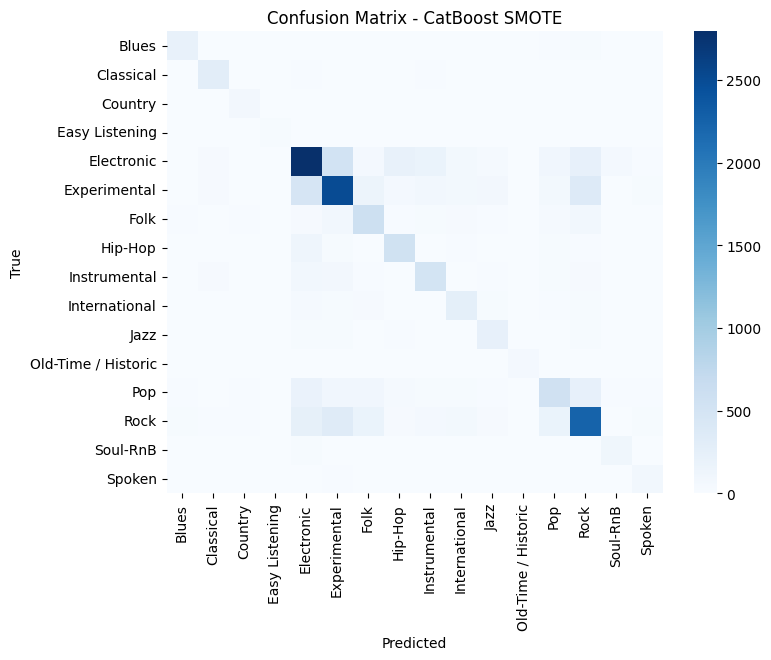

In [ ]:
# second scenario evaluation
evaluate_model("CatBoost SMOTE", y_train_sm, y_pred_cb_sm_train, y_test_sm, y_pred_cb_sm_test, label_encoder)


===== CatBoost SMOTE + LDA =====

train performance:
accuracy: 0.6780687339239783
macro F1: 0.669996997367931

test performance:
accuracy: 0.40287890668757703
macro F1: 0.33068813005342634

classification report (test):
                     precision    recall  f1-score   support

              Blues       0.26      0.46      0.33       310
          Classical       0.38      0.64      0.48       367
            Country       0.12      0.50      0.20       109
     Easy Listening       0.02      0.12      0.03        34
         Electronic       0.61      0.38      0.47      4373
       Experimental       0.57      0.38      0.46      3974
               Folk       0.33      0.40      0.36       984
            Hip-Hop       0.36      0.56      0.44       785
       Instrumental       0.23      0.39      0.29       836
      International       0.21      0.36      0.26       484
               Jazz       0.16      0.44      0.23       382
Old-Time / Historic       0.47      0.81      

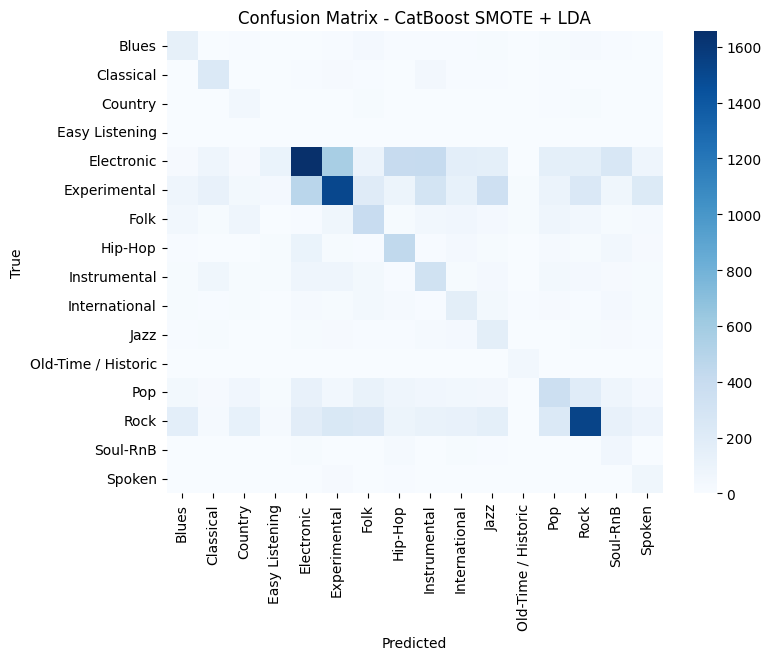

In [ ]:
# third scenario evaluation
evaluate_model("CatBoost SMOTE + LDA", y_train_sm, y_pred_cb_lda_train, y_test_sm, y_pred_cb_lda_test, label_encoder)

3. XGBoost


===== XGBoost RAW =====

train performance:
accuracy: 0.8853618236809678
macro F1: 0.9350641505433317

test performance:
accuracy: 0.6749747955640193
macro F1: 0.6097289484193155

classification report (test):
                     precision    recall  f1-score   support

              Blues       0.95      0.55      0.70       310
          Classical       0.88      0.69      0.78       367
            Country       0.97      0.28      0.43       109
     Easy Listening       1.00      0.18      0.30        34
         Electronic       0.64      0.78      0.71      4373
       Experimental       0.66      0.75      0.70      3974
               Folk       0.65      0.54      0.59       984
            Hip-Hop       0.81      0.60      0.69       785
       Instrumental       0.76      0.61      0.67       836
      International       0.77      0.37      0.50       484
               Jazz       0.75      0.35      0.48       382
Old-Time / Historic       0.97      0.86      0.91      

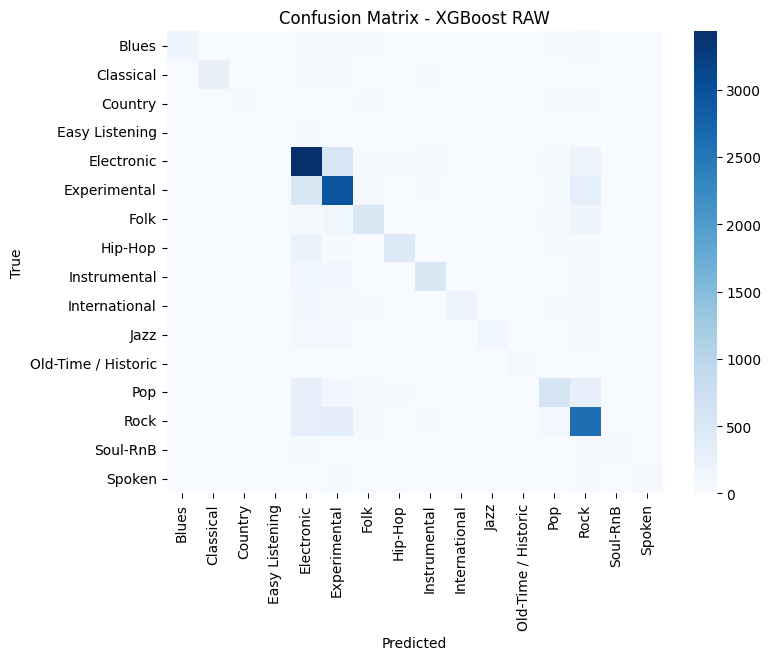

In [ ]:
# first scenario evaluation
evaluate_model("XGBoost RAW", y_train_raw, y_pred_xgb_raw_train, y_test_raw, y_pred_xgb_raw_test, label_encoder)


===== XGBoost SMOTE =====

train performance:
accuracy: 0.9463561017433553
macro F1: 0.9459123963810945

test performance:
accuracy: 0.6592360255404951
macro F1: 0.646916665694205

classification report (test):
                     precision    recall  f1-score   support

              Blues       0.77      0.65      0.70       310
          Classical       0.71      0.79      0.75       367
            Country       0.76      0.66      0.71       109
     Easy Listening       0.90      0.26      0.41        34
         Electronic       0.65      0.70      0.68      4373
       Experimental       0.67      0.69      0.68      3974
               Folk       0.60      0.61      0.61       984
            Hip-Hop       0.66      0.66      0.66       785
       Instrumental       0.65      0.66      0.65       836
      International       0.56      0.51      0.53       484
               Jazz       0.55      0.56      0.56       382
Old-Time / Historic       0.91      0.90      0.91     

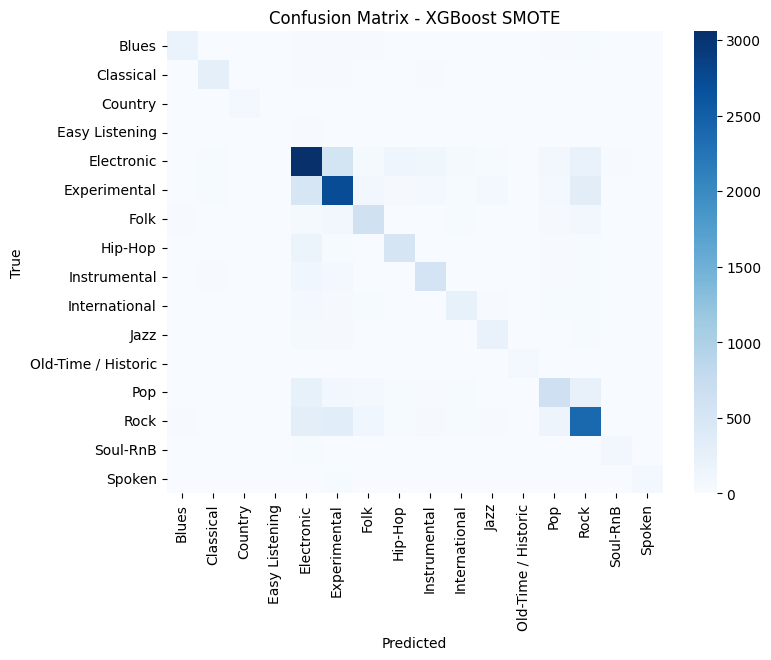

In [ ]:
# second scenario evaluation
evaluate_model("XGBoost SMOTE", y_train_sm, y_pred_xgb_sm_train, y_test_sm, y_pred_xgb_sm_test, label_encoder)


===== XGBoost SMOTE and LDA =====

train performance:
accuracy: 0.7276007430694484
macro F1: 0.7213532025407837

test performance:
accuracy: 0.4083678727456032
macro F1: 0.3320208238952526

classification report (test):
                     precision    recall  f1-score   support

              Blues       0.27      0.47      0.34       310
          Classical       0.37      0.63      0.47       367
            Country       0.12      0.45      0.19       109
     Easy Listening       0.02      0.09      0.03        34
         Electronic       0.59      0.39      0.47      4373
       Experimental       0.56      0.39      0.46      3974
               Folk       0.33      0.41      0.37       984
            Hip-Hop       0.37      0.56      0.44       785
       Instrumental       0.24      0.39      0.29       836
      International       0.21      0.36      0.27       484
               Jazz       0.15      0.39      0.22       382
Old-Time / Historic       0.49      0.78      

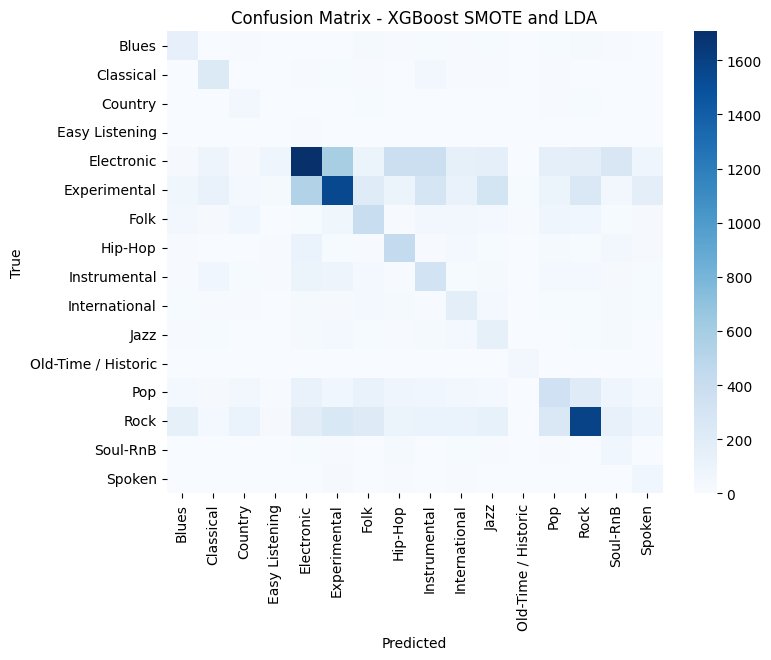

In [ ]:
# third scenario evaluation
evaluate_model("XGBoost SMOTE and LDA", y_train_sm, y_pred_xgb_lda_train, y_test_sm, y_pred_xgb_lda_test, label_encoder)

4. FNN (Evaluation)

558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.4149210261005937
Macro F1: 0.3572233627203594
              precision    recall  f1-score   support

           0       0.33      0.58      0.42       310
           1       0.33      0.76      0.46       367
           2       0.19      0.62      0.29       109
           3       0.08      0.26      0.13        34
           4       0.61      0.31      0.41      4373
           5       0.56      0.40      0.47      3974
           6       0.31      0.44      0.36       984
           7       0.33      0.64      0.43       785
           8       0.24      0.44      0.31       836
           9       0.21      0.41      0.28       484
          10       0.20      0.45      0.27       382
          11       0.45      0.87      0.59        69
          12       0.42      0.19      0.26      1366
          13       0.68      0.50      0.58      3488
          14       0.11      0.59      0.19       168
          15       0.16      0.56   

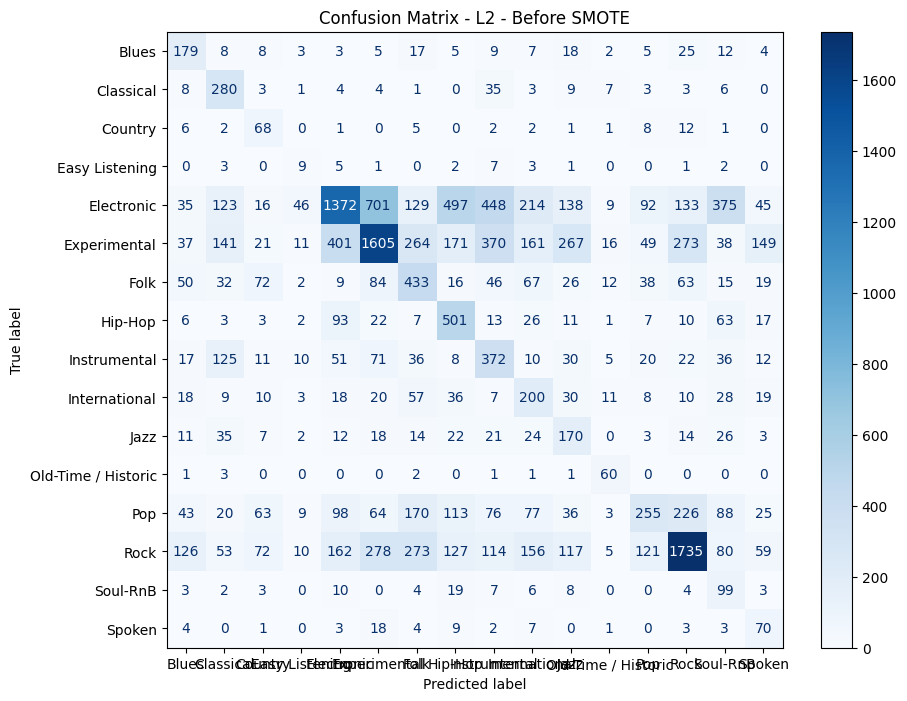

558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.5128822672790411
Macro F1: 0.43520766203586986
              precision    recall  f1-score   support

           0       0.67      0.48      0.56       310
           1       0.60      0.62      0.61       367
           2       0.66      0.21      0.32       109
           3       1.00      0.03      0.06        34
           4       0.53      0.63      0.57      4373
           5       0.57      0.46      0.51      3974
           6       0.40      0.49      0.44       984
           7       0.44      0.56      0.49       785
           8       0.38      0.42      0.40       836
           9       0.42      0.37      0.39       484
          10       0.32      0.32      0.32       382
          11       0.89      0.71      0.79        69
          12       0.38      0.25      0.30      1366
          13       0.57      0.62      0.59      3488
          14       0.33      0.18      0.24       168
          15       0.43      0.31  

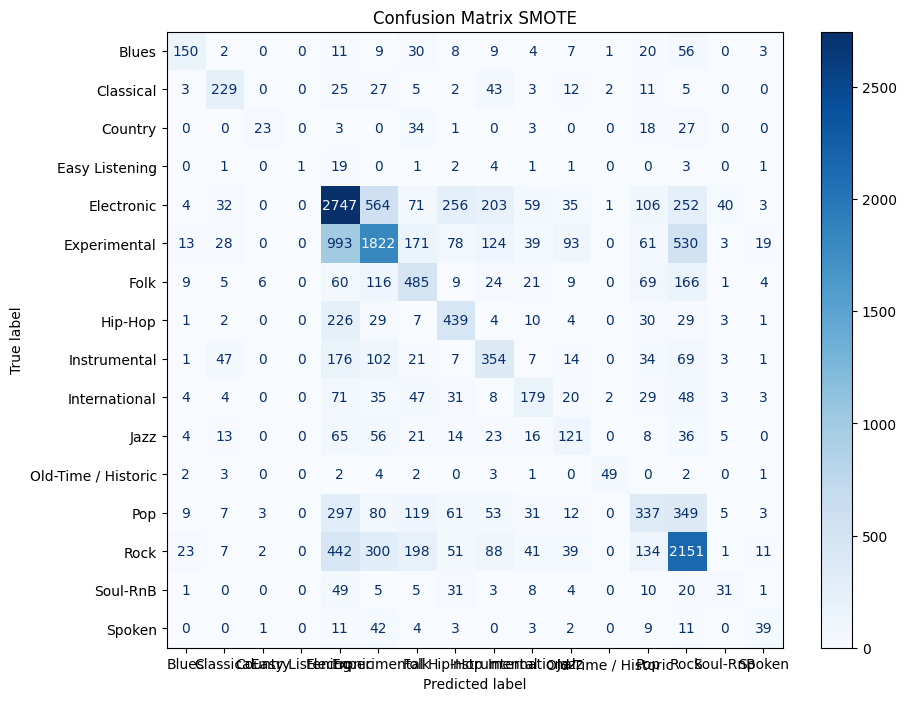

558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.1639408535902319
Macro F1: 0.09228215072650642
              precision    recall  f1-score   support

           0       0.05      0.09      0.06       310
           1       0.00      0.00      0.00       367
           2       0.02      0.18      0.04       109
           3       0.00      0.00      0.00        34
           4       0.33      0.13      0.18      4373
           5       0.37      0.25      0.30      3974
           6       0.13      0.15      0.14       984
           7       0.01      0.01      0.01       785
           8       0.05      0.13      0.07       836
           9       0.01      0.02      0.02       484
          10       0.11      0.27      0.16       382
          11       0.00      0.00      0.00        69
          12       0.18      0.15      0.16      1366
          13       0.46      0.21      0.29      3488
          14       0.02      0.12      0.04       168
          15       0.00      0.03  

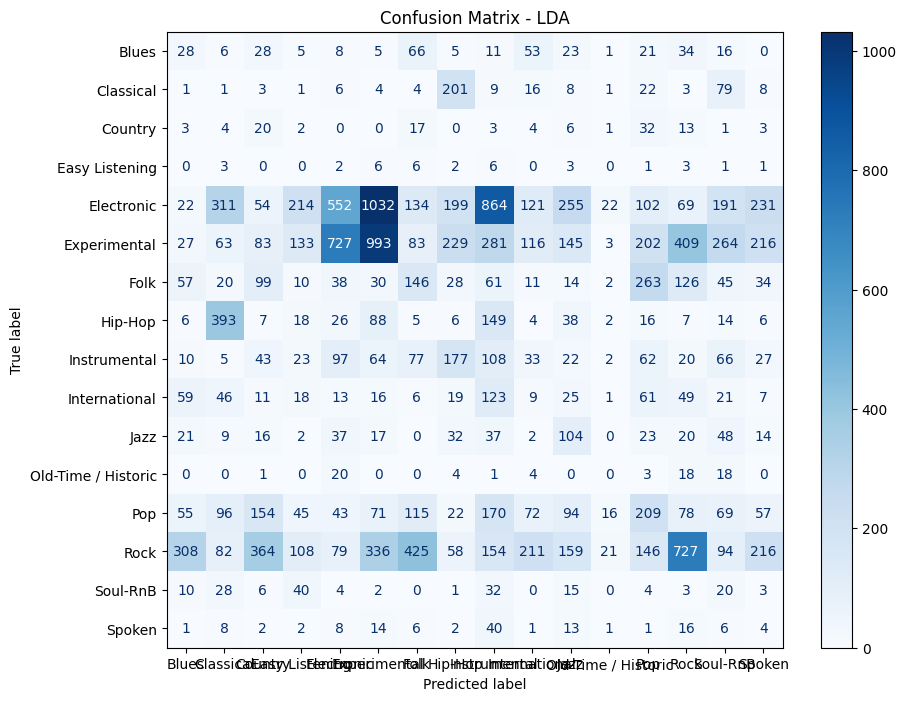

In [ ]:
# convert probability outputs to class indices
# S1

# macro metrics
y_pred = np.argmax(model_with_l2.predict(X_test_nn_ss), axis=1)
print("Accuracy:", M.accuracy_score(y_test_nn, y_pred))
print("Macro F1:", M.f1_score(y_test_nn, y_pred, average='macro'))
print(M.classification_report(y_test_nn, y_pred))

# compute confusion matrix
cm = confusion_matrix(y_test_nn, y_pred)

# genre names
genre_names = le.classes_.tolist()

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=genre_names)  # classes 0–15
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')

plt.title("Confusion Matrix - L2 - Before SMOTE")
plt.show()

# y_pred_fnn_l2_classes  = np.argmax(y_pred_fnn_l2, axis=1)

# evaluate_model(
#     "FNN with L2 on scaled data",
#     y_train_nn, y_train_pred_l2,
#     y_test_nn, y_pred_fnn_l2_classes,
#     label_encoder
# )
# ------------------
# S2
y_pred_smote = np.argmax(model_with_smote.predict(X_test_nn_ss), axis=1)
print("Accuracy:", M.accuracy_score(y_test_nn, y_pred_smote))
print("Macro F1:", M.f1_score(y_test_nn, y_pred_smote, average='macro'))
print(M.classification_report(y_test_nn, y_pred_smote))

# confusion matrix

# compute confusion matrix
cm = confusion_matrix(y_test_nn, y_pred_smote)

# genre names
genre_names = le.classes_.tolist()

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=genre_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')

plt.title("Confusion Matrix SMOTE")
plt.show()


# y_pred_fnn_sm_classes  = np.argmax(y_pred_fnn_sm, axis=1)

# evaluate_model(
#     "FNN with SMOTE",
#     y_train_nn, y_train_pred_sm,
#     y_test_nn, y_pred_fnn_sm_classes,
#     label_encoder
# )
# ------------------
# S3

# macro metrics
y_pred_lda = np.argmax(model_with_lda.predict(X_test_nn_lda), axis=1)
print("Accuracy:", M.accuracy_score(y_test_nn, y_pred_lda))
print("Macro F1:", M.f1_score(y_test_nn, y_pred_lda, average='macro'))
print(M.classification_report(y_test_nn, y_pred_lda))

# compute confusion matrix
cm = confusion_matrix(y_test_nn, y_pred_lda)

# genre names
genre_names = le.classes_.tolist()

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=genre_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')

plt.title("Confusion Matrix - LDA")
plt.show()

# y_pred_fnn_lda_classes = np.argmax(y_pred_fnn_lda, axis=1)

# evaluate_model(
#     "FNN with LDA",
#     y_train_nn, y_train_pred_lda,
#     y_test_nn, y_pred_fnn_lda_classes,
#     label_encoder
# )

### **unsupervised models**
##### **evaluate the performance of the models**

Multi stage clustring evaluation

unsupervised models evaluate the performance of the models here we use only silhouette_score(), and davies_bouldin_score()

1-Kmean Evaluation

In [ ]:
#compute the silhouette score for the kmean clusters
silhouette = silhouette_score(k_umap, km_labels)

#compute the devies-boudin index for kmean clusters
dbi = davies_bouldin_score(k_umap, km_labels)

#display the scores.
print("Silhouette Score:", round(silhouette, 3))
print("Davies-Bouldin Index:", round(dbi, 3))

Silhouette Score: 0.424
Davies-Bouldin Index: 0.834


2-Multi stage clustring evaluation

In [ ]:
#comute the silhouette score for multi stage clustering
silhouette2 = silhouette_score(m_umap[valid_mask], final_labels[valid_mask])

#compute the devies-boudin index for multi stage clustering.
dbi2 = davies_bouldin_score(m_umap[valid_mask], final_labels[valid_mask])

#display the scores.
print("Silhouette Score:", round(silhouette2, 3))
print("Davies-Bouldin Index:", round(dbi2, 3))

Silhouette Score: 0.428
Davies-Bouldin Index: 0.905


3-HDBSCAN

In [ ]:
sil = silhouette_score(X[not_noise], y_pred[not_noise]) if not_noise.sum() > 1 else -1
ari = adjusted_rand_score(y, y_pred)
nmi = normalized_mutual_info_score(y, y_pred)
comparison = pd.crosstab(y, y_pred)


print("Silhouette:", round(sil,5))
print("Adjusted Rand Index (ARI):", round(ari,5))
print("Normalized Mutual Information (NMI):", round(nmi,5))
print(comparison)

Silhouette: 0.50968
Adjusted Rand Index (ARI): 0.00084
Normalized Mutual Information (NMI): 0.00576
col_0   -1     0    1    2    3    4    5    6    7    8   ...   35   36   37  \
row_0                                                      ...                  
0       525    93   42    0   64   31    9    2    0    9  ...    2    5   10   
1       629    83   78    1   41   40    6    1    1   11  ...    2    3    6   
2       155    21   17    6   14    3    1    1    1    1  ...    0    1    1   
3        73    12    0    0   11    4    0    0    0    0  ...    0    1    2   
4      7016  1191  549   10  607  315   71   24   23   93  ...   20   54  135   
5      6966  1121  480   13  585  385   58   32   18  115  ...   14   50  128   
6      1575   242  190    1  178   51   15    9    8   25  ...    8   15   25   
7      1312   195  187    1  164   82   10    1    5   22  ...    3    6   23   
8       932   153   92    0   55   40   20    0    4   14  ...    0    5   23   
9       9

## ---------------------------------------------------------
##  **⭐ Comparison Step: Compare Models and Select the Best**
## ---------------------------------------------------------


### **Compare supervised models then select the best**


In [ ]:
import pandas as pd

results = []

def add_result(model_name, scenario, y_true, y_pred):
    results.append({
        "model": model_name,
        "scenario": scenario,
        "accuracy": accuracy_score(y_true, y_pred),
        "macro F1": f1_score(y_true, y_pred, average='macro')
    })

# Random Forest
add_result("random forest", "RAW", y_test_raw, y_pred_rf_raw_test)
add_result("random forest", "SMOTE", y_test_sm, y_pred_rf_sm_test)
add_result("random forest", "SMOTE + LDA", y_test_sm, y_pred_rf_lda_test)

# XGBoost
add_result("XGBoost", "RAW", y_test_raw, y_pred_xgb_raw_test)
add_result("XGBoost", "SMOTE", y_test_sm, y_pred_xgb_sm_test)
add_result("XGBoost", "SMOTE + LDA", y_test_sm, y_pred_xgb_lda_test)

# CatBoost
add_result("CatBoost", "RAW", y_test_raw, y_pred_cb_raw_test)
add_result("CatBoost", "SMOTE", y_test_sm, y_pred_cb_sm_test)
add_result("CatBoost", "SMOTE + LDA", y_test_sm, y_pred_cb_lda_test)

# FNN
# with L2 on scaled data
add_result("FNN", "L2 + Scaled", y_test_nn_ss, y_pred_fnn_l2_classes)

# with SMOTE
add_result("FNN", "SMOTE", y_test_nn_sm, y_pred_fnn_sm_classes)

# with LDA
add_result("FNN", "LDA", y_test_nn_lda, y_pred_fnn_lda_classes)


df_results = pd.DataFrame(results)
df_results

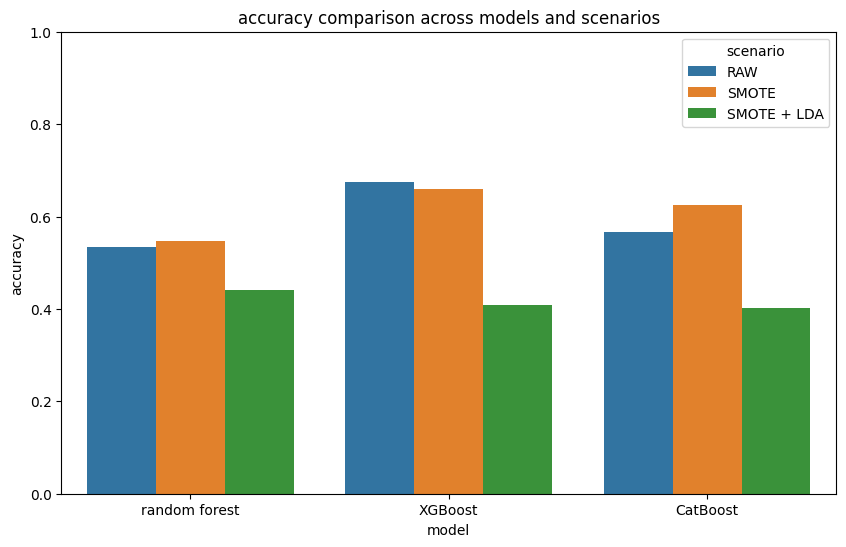

In [ ]:
# accuracy comparison plot
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="model", y="accuracy", hue="scenario")
plt.title("accuracy comparison across models and scenarios")
plt.ylim(0,1)
plt.show()

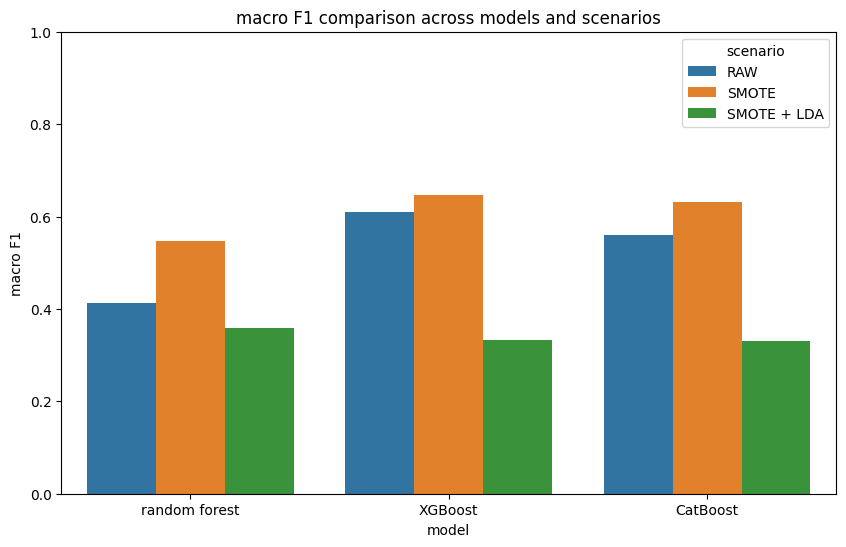

In [ ]:
# macro-F1 comparison plot
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="model", y="macro F1", hue="scenario")
plt.title("macro F1 comparison across models and scenarios")
plt.ylim(0,1)
plt.show()

In [ ]:
# identify the best model
best_row = df_results.iloc[df_results["macro F1"].idxmax()]
print("best (supervised) model overall:")
print(best_row)

best (supervised) model overall:
model        XGBoost
scenario       SMOTE
accuracy    0.659236
macro F1    0.646917
Name: 4, dtype: object


### **Compare unsupervised models then select the best**

1)Kmean model

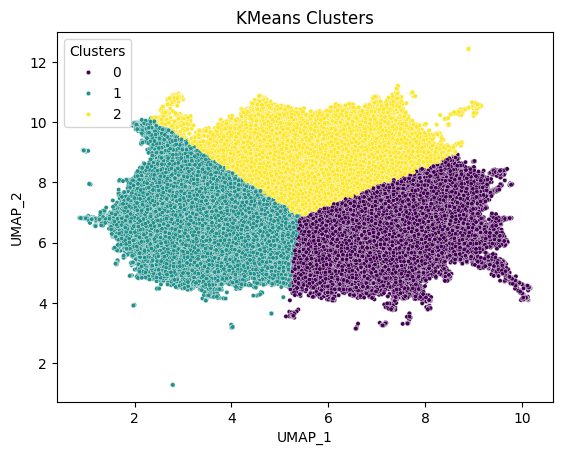

In [ ]:
# Visualize KMeans clusters on the 2D UMAP embedding.
sns.scatterplot(
    x=k_umap[:,0],
    y=k_umap[:,1],
    hue=km_labels,
    palette="viridis",
    s=10
)
plt.title("KMeans Clusters")
plt.xlabel("UMAP_1")
plt.ylabel("UMAP_2")
plt.legend(title="Clusters")
plt.show()

2)Multi stage

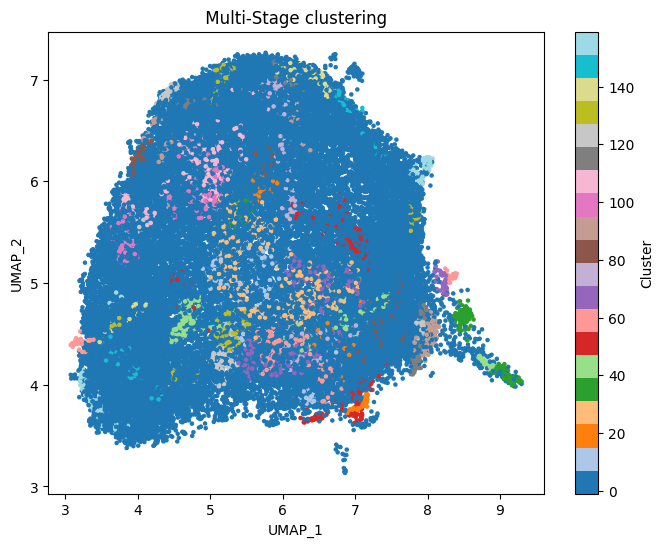

In [ ]:
# Visualize the final Multi-Stage clustering results on the 2D UMAP projection.
plt.figure(figsize=(8,6))
plt.scatter(m_umap[:,0], m_umap[:,1], c=final_labels, cmap='tab20', s=5)
plt.title(" Multi-Stage clustering ")
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.colorbar(label='Cluster')
plt.show()

3-HDBSCAN

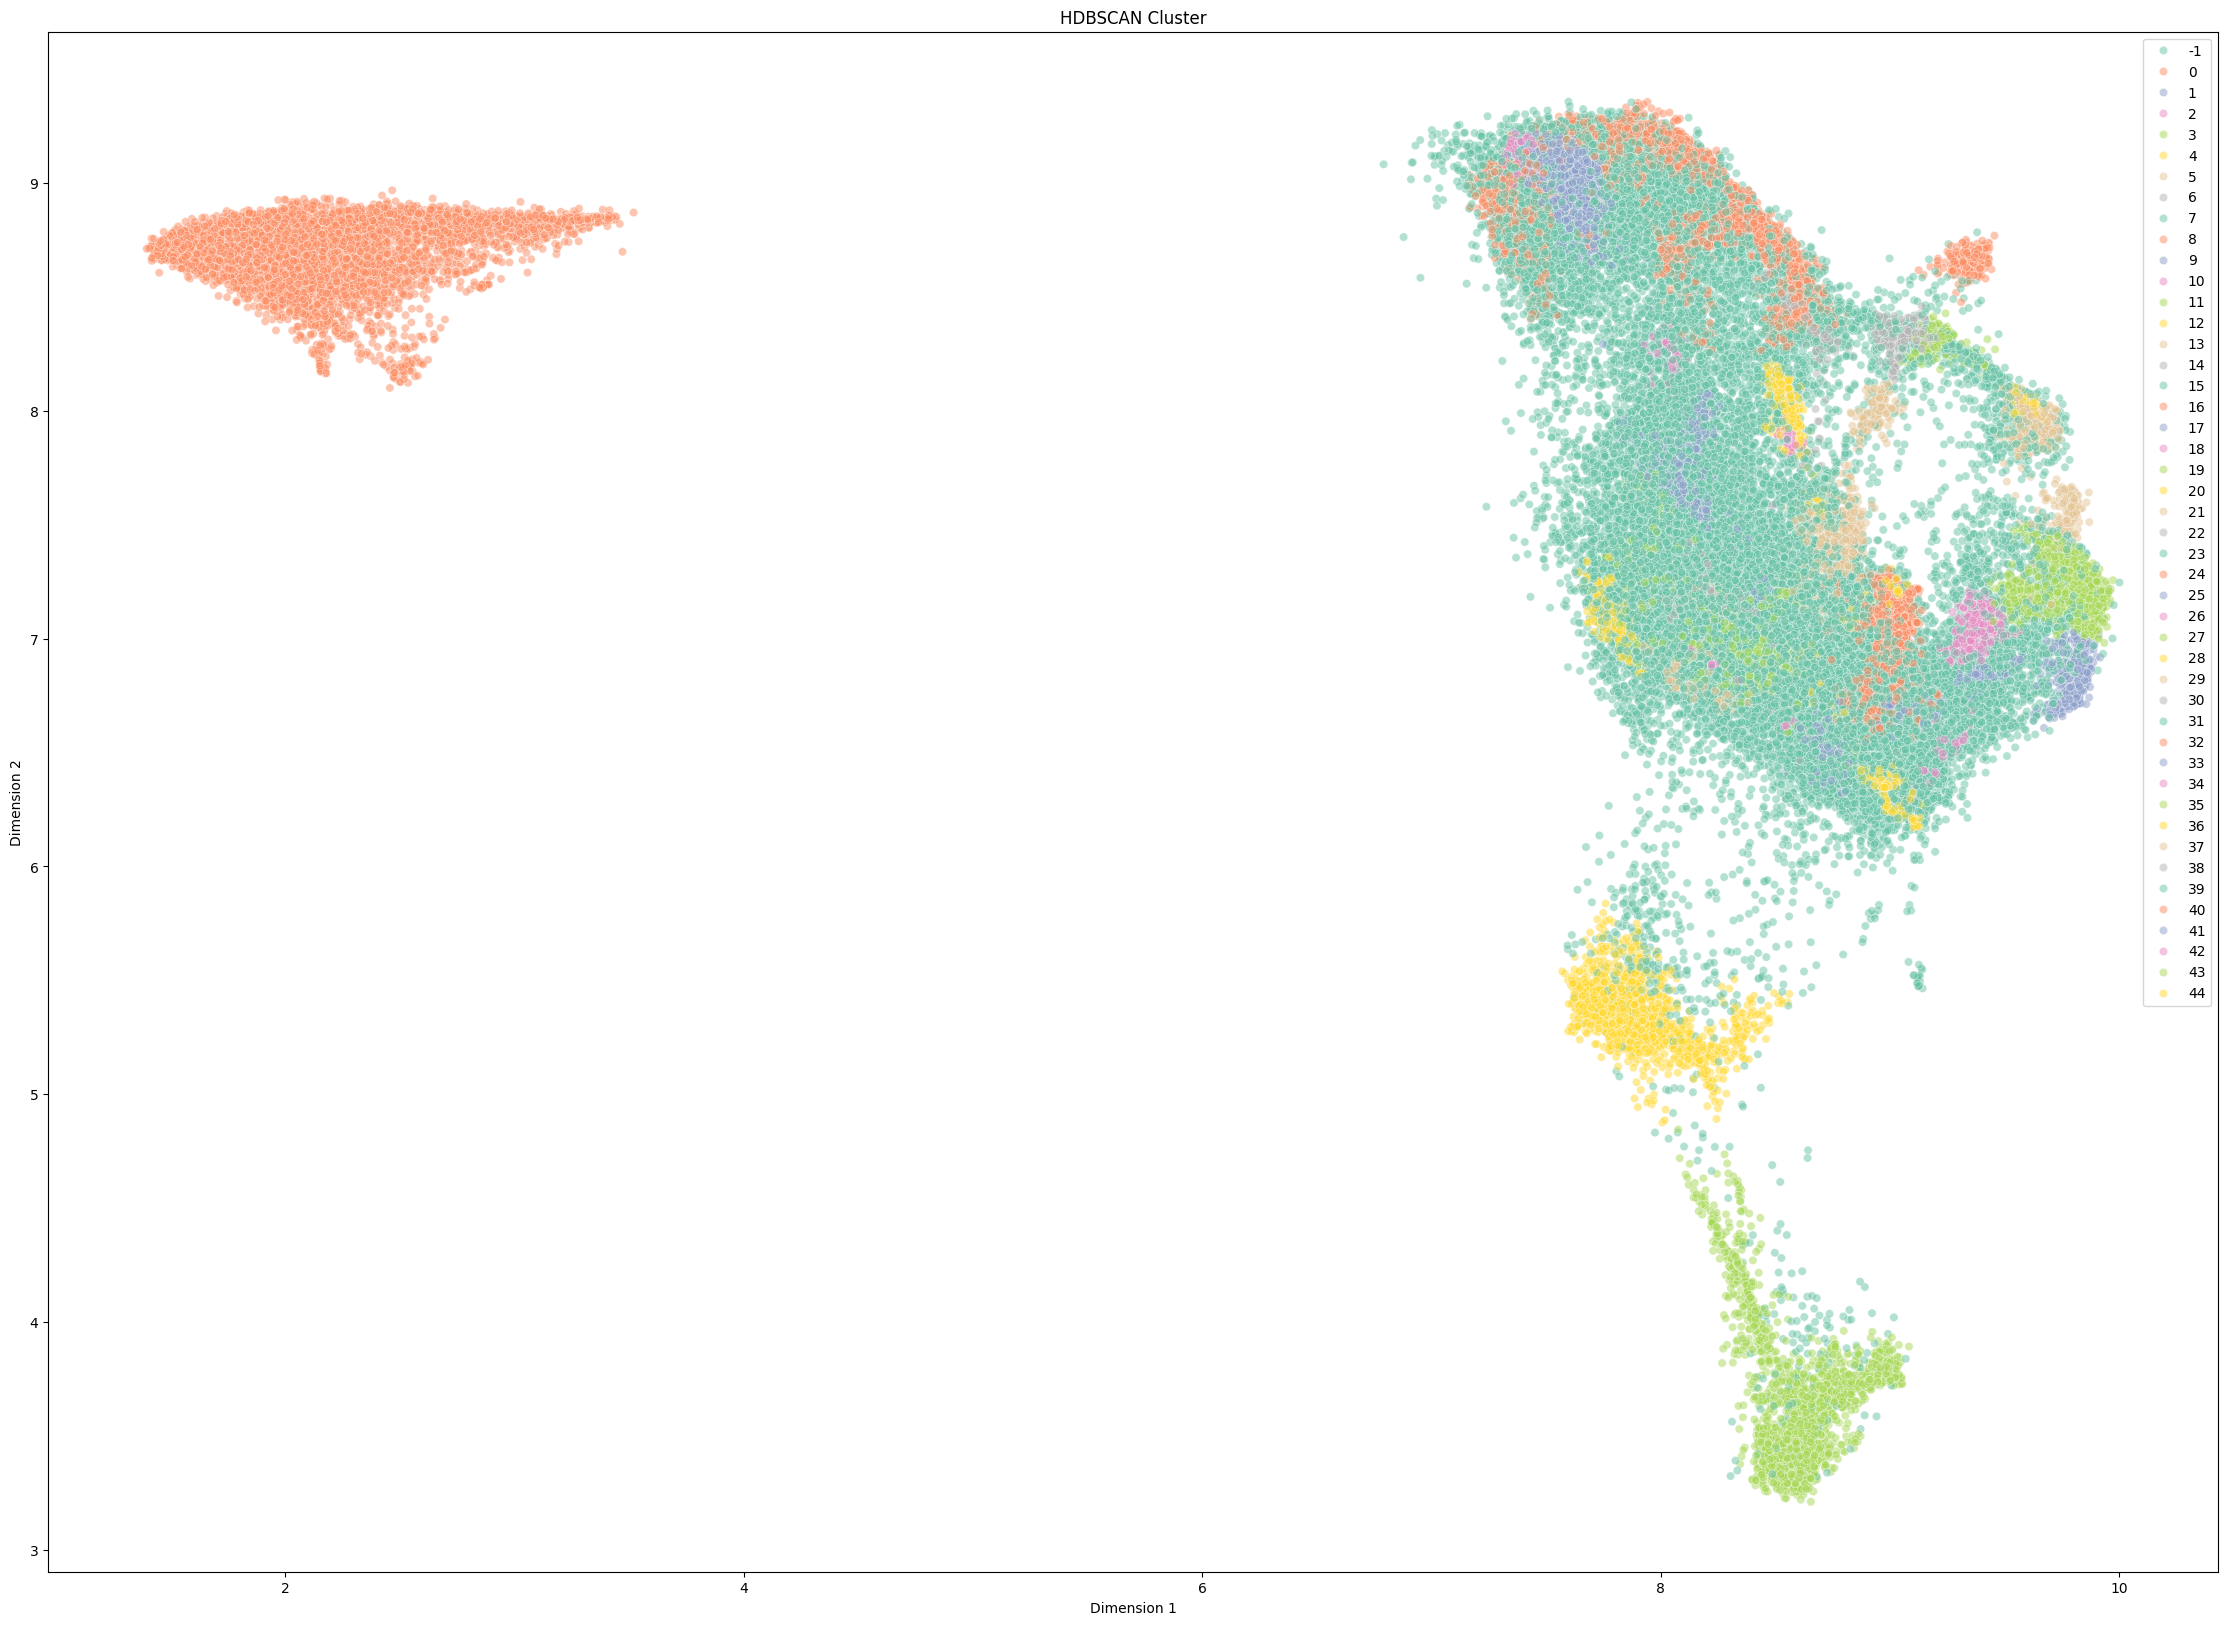

In [ ]:
# Visualize the clustering resulte of HDBSCAN.

plt.figure(figsize=(28, 20))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred , palette="Set2", alpha=0.5)
plt.title("HDBSCAN Cluster") #with UMAP
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

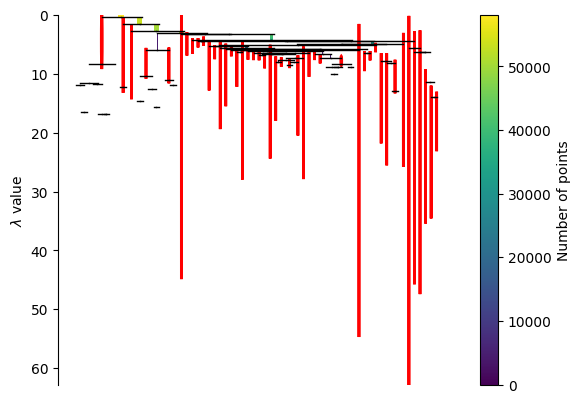

In [ ]:
#condensed tree
hdbscann.condensed_tree_.plot(select_clusters=True)
plt.show()